In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 1

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_multiome_phase2_mod2/openproblems_bmmc_multiome_phase2_mod2.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 42492 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 42492 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 116490
    obs: 'batch'
    var: 'feature_types'
    uns: 'dataset_id', 'gene_activity_var_names', 'organism'
    obsm: 'gene_activity'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13431
    obs: 'batch'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d10', 's3d3', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
mod2_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
mod2_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
mod2_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
mod2_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
mod2_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
mod2_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

mod2_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
mod2_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
mod2_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

mod2_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
mod2_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
mod2_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [9]:
mod2_s1d1 = mod2_s1d1.X.toarray()
mod2_s1d2 = mod2_s1d2.X.toarray()
mod2_s1d3 = mod2_s1d3.X.toarray()
mod2_s2d1 = mod2_s2d1.X.toarray()
mod2_s2d4 = mod2_s2d4.X.toarray()
mod2_s2d5 = mod2_s2d5.X.toarray()

mod2_s3d1 = mod2_s3d1.X.toarray()
mod2_s3d6 = mod2_s3d6.X.toarray()
mod2_s3d7 = mod2_s3d7.X.toarray()

mod2_s4d1 = mod2_s4d1.X.toarray()
mod2_s4d8 = mod2_s4d8.X.toarray()
mod2_s4d9 = mod2_s4d9.X.toarray()

In [10]:
print(mod2_s1d1.shape)
print(mod2_s4d1.shape)

(5616, 13431)
(415, 13431)


In [11]:
mod1_train = pd.read_csv('train_atac_counts_8000var_features.csv')
mod1_test = pd.read_csv('test_atac_counts_8000var_features.csv')

In [12]:
mod1_train = mod1_train.transpose()
mod1_test = mod1_test.transpose()

In [13]:
mod1_train['batch'] = mod1_train.index.str[-4:]
mod1_test['batch'] = mod1_test.index.str[-4:]

In [14]:
mod1_train = mod1_train.iloc[1:, :]
mod1_train.reset_index(drop=True, inplace=True)

mod1_test = mod1_test.iloc[1:, :]
mod1_test.reset_index(drop=True, inplace=True)

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']

['s4d1', 's4d8', 's4d9']

In [15]:
mod1_s1d1 = mod1_train[mod1_train['batch'] == 's1d1']
mod1_s1d2 = mod1_train[mod1_train['batch'] == 's1d2']
mod1_s1d3 = mod1_train[mod1_train['batch'] == 's1d3']
mod1_s2d1 = mod1_train[mod1_train['batch'] == 's2d1']
mod1_s2d4 = mod1_train[mod1_train['batch'] == 's2d4']
mod1_s2d5 = mod1_train[mod1_train['batch'] == 's2d5']
mod1_s3d1 = mod1_train[mod1_train['batch'] == 's3d1']
mod1_s3d6 = mod1_train[mod1_train['batch'] == 's3d6']
mod1_s3d7 = mod1_train[mod1_train['batch'] == 's3d7']

In [16]:
mod1_s4d1 = mod1_test[mod1_test['batch'] == 's4d1']
mod1_s4d8 = mod1_test[mod1_test['batch'] == 's4d8']
mod1_s4d9 = mod1_test[mod1_test['batch'] == 's4d9']

In [17]:
batch_s1d1 = mod1_s1d1["batch"]
batch_s1d2 = mod1_s1d2["batch"]
batch_s1d3 = mod1_s1d3["batch"]
batch_s2d1 = mod1_s2d1["batch"]
batch_s2d4 = mod1_s2d4["batch"]
batch_s2d5 = mod1_s2d5["batch"]

batch_s3d1 = mod1_s3d1["batch"]
batch_s3d6 = mod1_s3d6["batch"]
batch_s3d7 = mod1_s3d7["batch"]

batch_s4d1 = mod1_s4d1["batch"]
batch_s4d8 = mod1_s4d8["batch"]
batch_s4d9 = mod1_s4d9["batch"]

In [18]:
mod1_s1d1 = mod1_s1d1.drop('batch', axis=1)
mod1_s1d2 = mod1_s1d2.drop('batch', axis=1)
mod1_s1d3 = mod1_s1d3.drop('batch', axis=1)
mod1_s2d1 = mod1_s2d1.drop('batch', axis=1)
mod1_s2d4 = mod1_s2d4.drop('batch', axis=1)
mod1_s2d5 = mod1_s2d5.drop('batch', axis=1)

mod1_s3d1 = mod1_s3d1.drop('batch', axis=1)
mod1_s3d6 = mod1_s3d6.drop('batch', axis=1)
mod1_s3d7 = mod1_s3d7.drop('batch', axis=1)

mod1_s4d1 = mod1_s4d1.drop('batch', axis=1)
mod1_s4d8 = mod1_s4d8.drop('batch', axis=1)
mod1_s4d9 = mod1_s4d9.drop('batch', axis=1)

In [19]:
mod1_s1d1 = mod1_s1d1.to_numpy()
mod1_s1d2 = mod1_s1d2.to_numpy()
mod1_s1d3 = mod1_s1d3.to_numpy()
mod1_s2d1 = mod1_s2d1.to_numpy()
mod1_s2d4 = mod1_s2d4.to_numpy()
mod1_s2d5 = mod1_s2d5.to_numpy()

mod1_s3d1 = mod1_s3d1.to_numpy()
mod1_s3d6 = mod1_s3d6.to_numpy()
mod1_s3d7 = mod1_s3d7.to_numpy()

mod1_s4d1 = mod1_s4d1.to_numpy()
mod1_s4d8 = mod1_s4d8.to_numpy()
mod1_s4d9 = mod1_s4d9.to_numpy()

In [20]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [21]:
train_input = [mod1_s1d1, mod1_s1d2, mod1_s1d3, mod1_s2d1, mod1_s2d4, mod1_s2d5]
train_output = [mod2_s1d1, mod2_s1d2, mod2_s1d3, mod2_s2d1, mod2_s2d4, mod2_s2d5]

val_input = [mod1_s3d1, mod1_s3d6, mod1_s3d7]
val_output = [mod2_s3d1, mod2_s3d6, mod2_s3d7]

test_input = [mod1_s4d1, mod1_s4d8, mod1_s4d9]
test_output = [mod2_s4d1, mod2_s4d8, mod2_s4d9]

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(37087, 8000)
(7865, 8000)
(1000, 8000)


In [25]:
print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

(37087, 13431)
(7865, 13431)
(1000, 13431)


In [26]:
train_input = np.float64(train_input)
train_output = np.float64(train_output)
val_input = np.float64(val_input)
val_output = np.float64(val_output)
test_input = np.float64(test_input)
test_output = np.float64(test_output)

In [27]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [28]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [29]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [31]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [32]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [33]:
batch_train = batch_train + batch_val

In [34]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([37087, 1])

In [35]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([7865, 1])

In [36]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 1])

In [37]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [38]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [39]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [40]:
PATH = 'No_norm_model_DNA_RNA_counts'

In [41]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (13, 3*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  0.12926106  Validation_loss:  0.1380525  Test_loss:  0.117013685


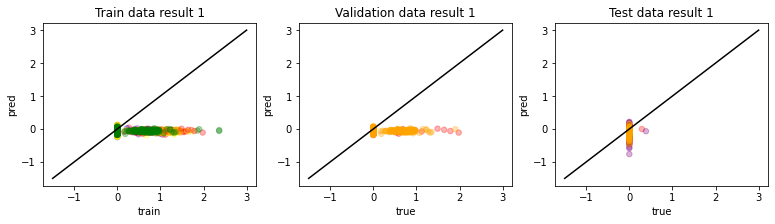

Epoch  100 Train_loss:  0.10807674  Validation_loss:  0.11576116  Test_loss:  0.09250927
Epoch  200 Train_loss:  0.10729331  Validation_loss:  0.11493596  Test_loss:  0.09054348
Epoch  300 Train_loss:  0.10679492  Validation_loss:  0.11443708  Test_loss:  0.08872148
Epoch  400 Train_loss:  0.10638088  Validation_loss:  0.11403072  Test_loss:  0.08704978
Epoch  500 Train_loss:  0.106011294  Validation_loss:  0.113669895  Test_loss:  0.08548813
Epoch  600 Train_loss:  0.10567333  Validation_loss:  0.113338955  Test_loss:  0.08415105
Epoch  700 Train_loss:  0.10536066  Validation_loss:  0.11303164  Test_loss:  0.08297295
Epoch  800 Train_loss:  0.1050689  Validation_loss:  0.11274287  Test_loss:  0.081934355
Epoch  900 Train_loss:  0.10479496  Validation_loss:  0.112470485  Test_loss:  0.081021085
Epoch  1000 Train_loss:  0.10453666  Validation_loss:  0.112212814  Test_loss:  0.080167495


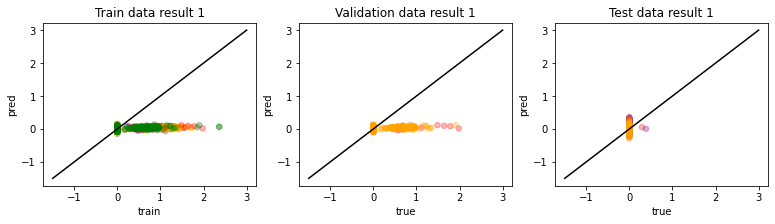

Epoch  1100 Train_loss:  0.10429132  Validation_loss:  0.11196609  Test_loss:  0.07941732
Epoch  1200 Train_loss:  0.1040579  Validation_loss:  0.1117301  Test_loss:  0.07873674
Epoch  1300 Train_loss:  0.10383502  Validation_loss:  0.11150392  Test_loss:  0.07810303
Epoch  1400 Train_loss:  0.103622116  Validation_loss:  0.11128693  Test_loss:  0.07751755
Epoch  1500 Train_loss:  0.10341747  Validation_loss:  0.11107745  Test_loss:  0.076996885
Epoch  1600 Train_loss:  0.10322074  Validation_loss:  0.110875584  Test_loss:  0.07648245
Epoch  1700 Train_loss:  0.10303148  Validation_loss:  0.11068015  Test_loss:  0.076037355
Epoch  1800 Train_loss:  0.102848984  Validation_loss:  0.110491514  Test_loss:  0.07561013
Epoch  1900 Train_loss:  0.10267279  Validation_loss:  0.110308655  Test_loss:  0.075214215
Epoch  2000 Train_loss:  0.102502204  Validation_loss:  0.11013095  Test_loss:  0.074832834


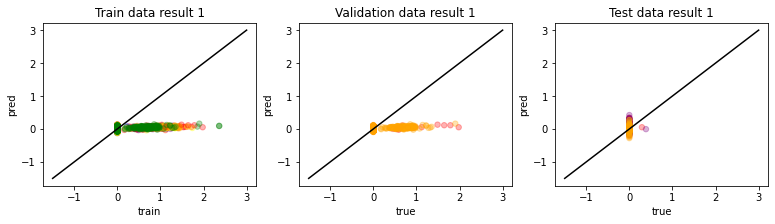

Epoch  2100 Train_loss:  0.10233691  Validation_loss:  0.10995801  Test_loss:  0.07450829
Epoch  2200 Train_loss:  0.10217653  Validation_loss:  0.109790206  Test_loss:  0.07417879
Epoch  2300 Train_loss:  0.10202042  Validation_loss:  0.10962607  Test_loss:  0.07386796
Epoch  2400 Train_loss:  0.101868585  Validation_loss:  0.10946582  Test_loss:  0.073612064
Epoch  2500 Train_loss:  0.10172061  Validation_loss:  0.10930894  Test_loss:  0.07334805
Epoch  2600 Train_loss:  0.101575956  Validation_loss:  0.1091559  Test_loss:  0.07310967
Epoch  2700 Train_loss:  0.1014349  Validation_loss:  0.109005675  Test_loss:  0.07288505
Epoch  2800 Train_loss:  0.101297125  Validation_loss:  0.10885849  Test_loss:  0.072690465
Epoch  2900 Train_loss:  0.10116212  Validation_loss:  0.10871457  Test_loss:  0.07245816
Epoch  3000 Train_loss:  0.10103001  Validation_loss:  0.10857324  Test_loss:  0.072283275


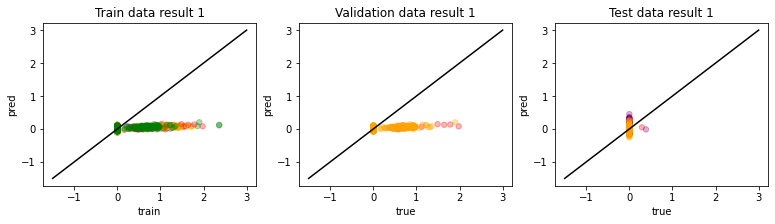

Epoch  3100 Train_loss:  0.10090039  Validation_loss:  0.10843444  Test_loss:  0.07209679
Epoch  3200 Train_loss:  0.10077337  Validation_loss:  0.10829801  Test_loss:  0.07192407
Epoch  3300 Train_loss:  0.10064848  Validation_loss:  0.10816331  Test_loss:  0.07177809
Epoch  3400 Train_loss:  0.100525804  Validation_loss:  0.10803091  Test_loss:  0.071637765
Epoch  3500 Train_loss:  0.10040521  Validation_loss:  0.10790015  Test_loss:  0.07151657
Epoch  3600 Train_loss:  0.10028635  Validation_loss:  0.10777157  Test_loss:  0.07139148
Epoch  3700 Train_loss:  0.100169204  Validation_loss:  0.10764479  Test_loss:  0.07128338
Epoch  3800 Train_loss:  0.10005395  Validation_loss:  0.107519746  Test_loss:  0.07117808
Epoch  3900 Train_loss:  0.09994011  Validation_loss:  0.107395686  Test_loss:  0.07109096
Epoch  4000 Train_loss:  0.09982785  Validation_loss:  0.107273586  Test_loss:  0.071011096


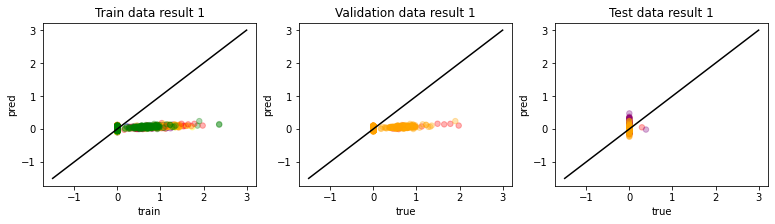

Epoch  4100 Train_loss:  0.09971666  Validation_loss:  0.10715208  Test_loss:  0.070939735
Epoch  4200 Train_loss:  0.09960698  Validation_loss:  0.10703195  Test_loss:  0.07087551
Epoch  4300 Train_loss:  0.09949852  Validation_loss:  0.10691292  Test_loss:  0.07082099
Epoch  4400 Train_loss:  0.09939134  Validation_loss:  0.106794916  Test_loss:  0.070770435
Epoch  4500 Train_loss:  0.09928492  Validation_loss:  0.10667782  Test_loss:  0.07073169
Epoch  4600 Train_loss:  0.09917983  Validation_loss:  0.10656225  Test_loss:  0.070682004
Epoch  4700 Train_loss:  0.09907565  Validation_loss:  0.1064473  Test_loss:  0.070640355
Epoch  4800 Train_loss:  0.098972194  Validation_loss:  0.106333025  Test_loss:  0.07062742
Epoch  4900 Train_loss:  0.09886956  Validation_loss:  0.10621972  Test_loss:  0.070598386
Epoch  5000 Train_loss:  0.098767586  Validation_loss:  0.10610638  Test_loss:  0.07061642


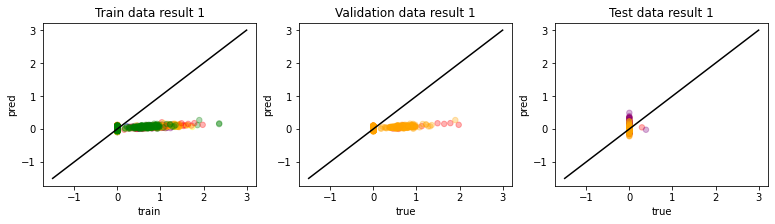

Epoch  5100 Train_loss:  0.09866636  Validation_loss:  0.105993874  Test_loss:  0.070616625
Epoch  5200 Train_loss:  0.09856591  Validation_loss:  0.105881654  Test_loss:  0.07062359
Epoch  5300 Train_loss:  0.098465875  Validation_loss:  0.10577048  Test_loss:  0.07062467
Epoch  5400 Train_loss:  0.09836661  Validation_loss:  0.1056594  Test_loss:  0.070653185
Epoch  5500 Train_loss:  0.09826755  Validation_loss:  0.105549395  Test_loss:  0.07067213
Epoch  5600 Train_loss:  0.09816919  Validation_loss:  0.1054388  Test_loss:  0.07071709
Epoch  5700 Train_loss:  0.09807119  Validation_loss:  0.10532874  Test_loss:  0.07074204
Epoch  5800 Train_loss:  0.09797372  Validation_loss:  0.10521954  Test_loss:  0.07074927
Epoch  5900 Train_loss:  0.09787654  Validation_loss:  0.105110295  Test_loss:  0.07077755
Epoch  6000 Train_loss:  0.09777962  Validation_loss:  0.105001315  Test_loss:  0.07082254


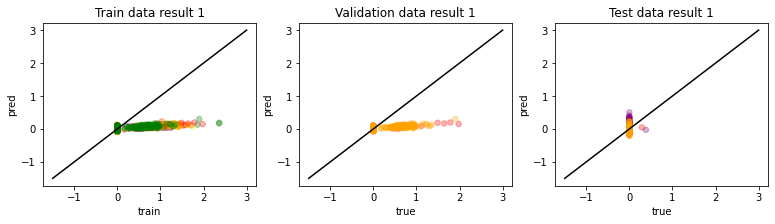

Epoch  6100 Train_loss:  0.097682975  Validation_loss:  0.10489222  Test_loss:  0.070865564
Epoch  6200 Train_loss:  0.09758682  Validation_loss:  0.104783505  Test_loss:  0.07091661
Epoch  6300 Train_loss:  0.097490765  Validation_loss:  0.1046748  Test_loss:  0.07096011
Epoch  6400 Train_loss:  0.09739494  Validation_loss:  0.10456631  Test_loss:  0.07101428
Epoch  6500 Train_loss:  0.09729921  Validation_loss:  0.10445831  Test_loss:  0.071056224
Epoch  6600 Train_loss:  0.0972037  Validation_loss:  0.104349576  Test_loss:  0.07114968
Epoch  6700 Train_loss:  0.09710842  Validation_loss:  0.10424148  Test_loss:  0.07120524
Epoch  6800 Train_loss:  0.09701305  Validation_loss:  0.10413317  Test_loss:  0.071258016
Epoch  6900 Train_loss:  0.09691791  Validation_loss:  0.104024775  Test_loss:  0.07136471
Epoch  7000 Train_loss:  0.09682274  Validation_loss:  0.10391634  Test_loss:  0.07144037


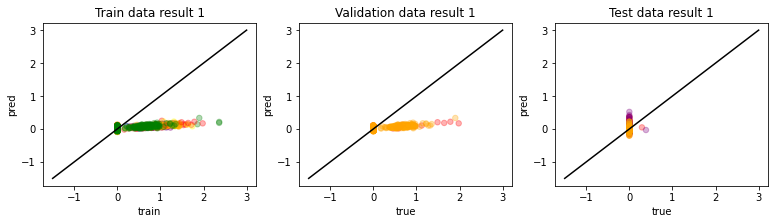

Epoch  7100 Train_loss:  0.096727654  Validation_loss:  0.10380823  Test_loss:  0.071504734
Epoch  7200 Train_loss:  0.09663264  Validation_loss:  0.10369994  Test_loss:  0.07156663
Epoch  7300 Train_loss:  0.096537694  Validation_loss:  0.10359119  Test_loss:  0.07166431
Epoch  7400 Train_loss:  0.096442655  Validation_loss:  0.10348274  Test_loss:  0.0717565
Epoch  7500 Train_loss:  0.09634753  Validation_loss:  0.10337381  Test_loss:  0.07185124
Epoch  7600 Train_loss:  0.09625228  Validation_loss:  0.10326452  Test_loss:  0.07197176
Epoch  7700 Train_loss:  0.0961568  Validation_loss:  0.10315578  Test_loss:  0.07203543
Epoch  7800 Train_loss:  0.09606165  Validation_loss:  0.10304627  Test_loss:  0.07215806
Epoch  7900 Train_loss:  0.095966324  Validation_loss:  0.10293686  Test_loss:  0.072283305
Epoch  8000 Train_loss:  0.09587071  Validation_loss:  0.10282732  Test_loss:  0.072372995


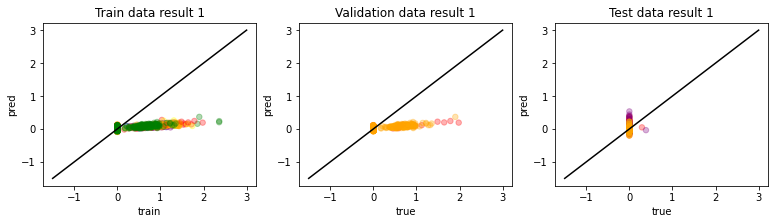

Epoch  8100 Train_loss:  0.095774956  Validation_loss:  0.10271752  Test_loss:  0.072477974
Epoch  8200 Train_loss:  0.09567903  Validation_loss:  0.102607064  Test_loss:  0.07257015
Epoch  8300 Train_loss:  0.09558309  Validation_loss:  0.102496795  Test_loss:  0.07269653
Epoch  8400 Train_loss:  0.09548667  Validation_loss:  0.10238601  Test_loss:  0.07280778
Epoch  8500 Train_loss:  0.09539034  Validation_loss:  0.102275  Test_loss:  0.07294332
Epoch  8600 Train_loss:  0.09529361  Validation_loss:  0.102163516  Test_loss:  0.07307226
Epoch  8700 Train_loss:  0.09519695  Validation_loss:  0.1020523  Test_loss:  0.07319335
Epoch  8800 Train_loss:  0.09509979  Validation_loss:  0.1019405  Test_loss:  0.0732971
Epoch  8900 Train_loss:  0.09500227  Validation_loss:  0.10182757  Test_loss:  0.07346167
Epoch  9000 Train_loss:  0.0949046  Validation_loss:  0.10171481  Test_loss:  0.07359682


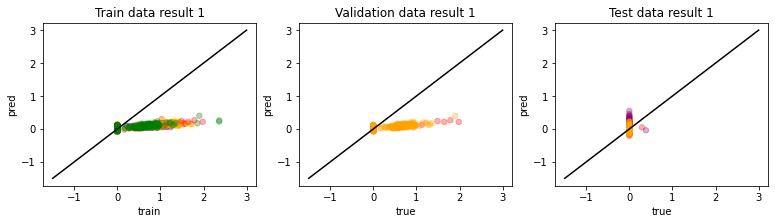

Epoch  9100 Train_loss:  0.09480699  Validation_loss:  0.101602115  Test_loss:  0.07370888
Epoch  9200 Train_loss:  0.09470859  Validation_loss:  0.101488754  Test_loss:  0.07386545
Epoch  9300 Train_loss:  0.0946102  Validation_loss:  0.101375096  Test_loss:  0.07399031
Epoch  9400 Train_loss:  0.094511405  Validation_loss:  0.10126092  Test_loss:  0.074154854
Epoch  9500 Train_loss:  0.094412394  Validation_loss:  0.10114619  Test_loss:  0.07429864
Epoch  9600 Train_loss:  0.094312705  Validation_loss:  0.10103087  Test_loss:  0.0744666
Epoch  9700 Train_loss:  0.094212964  Validation_loss:  0.10091555  Test_loss:  0.07460943
Epoch  9800 Train_loss:  0.09411278  Validation_loss:  0.10079924  Test_loss:  0.074773595
Epoch  9900 Train_loss:  0.09401235  Validation_loss:  0.100683145  Test_loss:  0.07493609
Epoch  10000 Train_loss:  0.093911625  Validation_loss:  0.10056624  Test_loss:  0.075076774


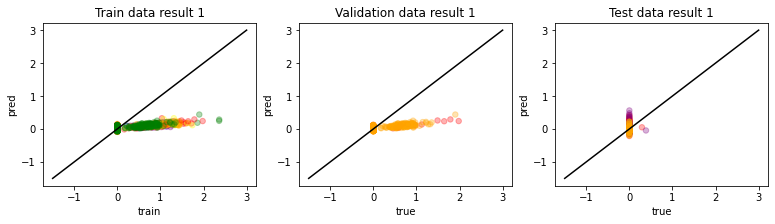

Epoch  10100 Train_loss:  0.09381024  Validation_loss:  0.10044926  Test_loss:  0.07523916
Epoch  10200 Train_loss:  0.09370877  Validation_loss:  0.10033135  Test_loss:  0.075415246
Epoch  10300 Train_loss:  0.09360661  Validation_loss:  0.10021323  Test_loss:  0.075566165
Epoch  10400 Train_loss:  0.093504354  Validation_loss:  0.10009465  Test_loss:  0.07574468
Epoch  10500 Train_loss:  0.09340161  Validation_loss:  0.099975705  Test_loss:  0.0759165
Epoch  10600 Train_loss:  0.093298554  Validation_loss:  0.099856265  Test_loss:  0.07609242
Epoch  10700 Train_loss:  0.0931947  Validation_loss:  0.09973612  Test_loss:  0.07627034
Epoch  10800 Train_loss:  0.09309088  Validation_loss:  0.099615306  Test_loss:  0.07644328
Epoch  10900 Train_loss:  0.092986636  Validation_loss:  0.099494375  Test_loss:  0.07662639
Epoch  11000 Train_loss:  0.09288166  Validation_loss:  0.09937278  Test_loss:  0.07680699


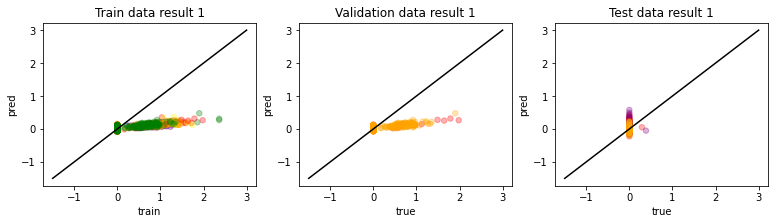

Epoch  11100 Train_loss:  0.09277634  Validation_loss:  0.09925068  Test_loss:  0.07699174
Epoch  11200 Train_loss:  0.092670746  Validation_loss:  0.099128194  Test_loss:  0.07717464
Epoch  11300 Train_loss:  0.09256464  Validation_loss:  0.099005245  Test_loss:  0.077366896
Epoch  11400 Train_loss:  0.092458345  Validation_loss:  0.098881245  Test_loss:  0.077567786
Epoch  11500 Train_loss:  0.09235092  Validation_loss:  0.09875719  Test_loss:  0.07775303
Epoch  11600 Train_loss:  0.09224378  Validation_loss:  0.09863257  Test_loss:  0.07793755
Epoch  11700 Train_loss:  0.092135824  Validation_loss:  0.098507166  Test_loss:  0.07814301
Epoch  11800 Train_loss:  0.09202752  Validation_loss:  0.0983814  Test_loss:  0.07834507
Epoch  11900 Train_loss:  0.09191902  Validation_loss:  0.09825546  Test_loss:  0.07849942
Epoch  12000 Train_loss:  0.091809824  Validation_loss:  0.09812865  Test_loss:  0.07873036


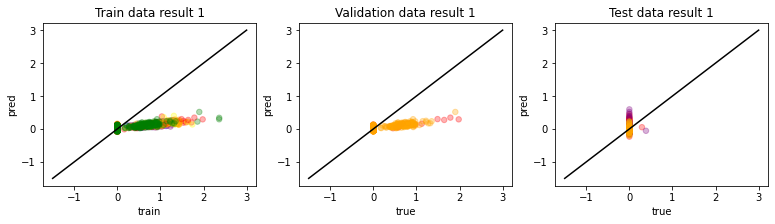

Epoch  12100 Train_loss:  0.09169997  Validation_loss:  0.098001175  Test_loss:  0.07891524
Epoch  12200 Train_loss:  0.09159006  Validation_loss:  0.097873956  Test_loss:  0.07908102
Epoch  12300 Train_loss:  0.09147919  Validation_loss:  0.09774521  Test_loss:  0.079296194
Epoch  12400 Train_loss:  0.09136796  Validation_loss:  0.09761632  Test_loss:  0.07950643
Epoch  12500 Train_loss:  0.09125654  Validation_loss:  0.097486824  Test_loss:  0.07971394
Epoch  12600 Train_loss:  0.09114457  Validation_loss:  0.09735704  Test_loss:  0.079908505
Epoch  12700 Train_loss:  0.09103195  Validation_loss:  0.09722675  Test_loss:  0.080099754
Epoch  12800 Train_loss:  0.090918906  Validation_loss:  0.0970955  Test_loss:  0.080317855
Epoch  12900 Train_loss:  0.090805285  Validation_loss:  0.09696381  Test_loss:  0.080521755
Epoch  13000 Train_loss:  0.0906912  Validation_loss:  0.09683177  Test_loss:  0.080734685


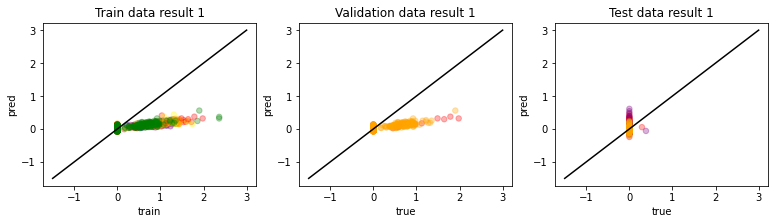

Epoch  13100 Train_loss:  0.090576425  Validation_loss:  0.09669895  Test_loss:  0.080954865
Epoch  13200 Train_loss:  0.09046121  Validation_loss:  0.0965655  Test_loss:  0.081155755
Epoch  13300 Train_loss:  0.09034563  Validation_loss:  0.09643138  Test_loss:  0.0813796
Epoch  13400 Train_loss:  0.090229444  Validation_loss:  0.096296914  Test_loss:  0.08160607
Epoch  13500 Train_loss:  0.090112895  Validation_loss:  0.09616244  Test_loss:  0.081795715
Epoch  13600 Train_loss:  0.08999585  Validation_loss:  0.09602666  Test_loss:  0.08200866
Epoch  13700 Train_loss:  0.08987793  Validation_loss:  0.09589057  Test_loss:  0.082240805
Epoch  13800 Train_loss:  0.08975972  Validation_loss:  0.09575388  Test_loss:  0.08247692
Epoch  13900 Train_loss:  0.08964094  Validation_loss:  0.095617056  Test_loss:  0.08267041
Epoch  14000 Train_loss:  0.08952187  Validation_loss:  0.09547923  Test_loss:  0.082895294


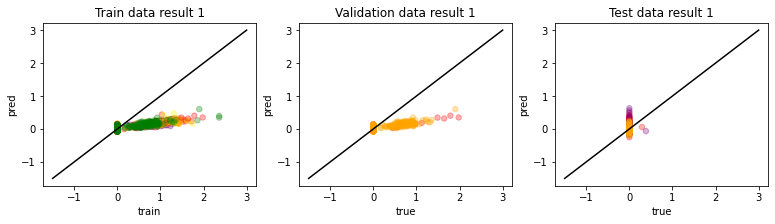

Epoch  14100 Train_loss:  0.08940233  Validation_loss:  0.09534065  Test_loss:  0.083118215
Epoch  14200 Train_loss:  0.08928193  Validation_loss:  0.09520187  Test_loss:  0.08330482
Epoch  14300 Train_loss:  0.08916098  Validation_loss:  0.09506186  Test_loss:  0.08355092
Epoch  14400 Train_loss:  0.08904016  Validation_loss:  0.09492161  Test_loss:  0.083790414
Epoch  14500 Train_loss:  0.088918224  Validation_loss:  0.09478098  Test_loss:  0.083999366
Epoch  14600 Train_loss:  0.08879538  Validation_loss:  0.0946395  Test_loss:  0.08424367
Epoch  14700 Train_loss:  0.08867258  Validation_loss:  0.09449713  Test_loss:  0.08448642
Epoch  14800 Train_loss:  0.08854929  Validation_loss:  0.094354846  Test_loss:  0.084668115
Epoch  14900 Train_loss:  0.08842536  Validation_loss:  0.09421178  Test_loss:  0.08487909
Epoch  15000 Train_loss:  0.0883007  Validation_loss:  0.094068184  Test_loss:  0.08512617


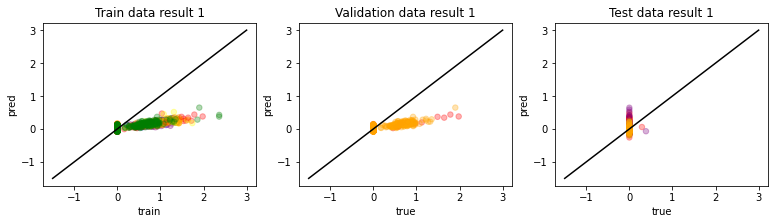

Epoch  15100 Train_loss:  0.088175915  Validation_loss:  0.09392365  Test_loss:  0.08538855
Epoch  15200 Train_loss:  0.08805019  Validation_loss:  0.093778625  Test_loss:  0.08561669
Epoch  15300 Train_loss:  0.08792412  Validation_loss:  0.09363321  Test_loss:  0.085840166
Epoch  15400 Train_loss:  0.08779773  Validation_loss:  0.09348715  Test_loss:  0.08608261
Epoch  15500 Train_loss:  0.087670125  Validation_loss:  0.0933407  Test_loss:  0.086312756
Epoch  15600 Train_loss:  0.087542035  Validation_loss:  0.09319353  Test_loss:  0.08655354
Epoch  15700 Train_loss:  0.087413885  Validation_loss:  0.0930456  Test_loss:  0.08681334
Epoch  15800 Train_loss:  0.08728497  Validation_loss:  0.092897154  Test_loss:  0.08704694
Epoch  15900 Train_loss:  0.087155715  Validation_loss:  0.09274815  Test_loss:  0.08725556
Epoch  16000 Train_loss:  0.08702523  Validation_loss:  0.092598505  Test_loss:  0.08748019


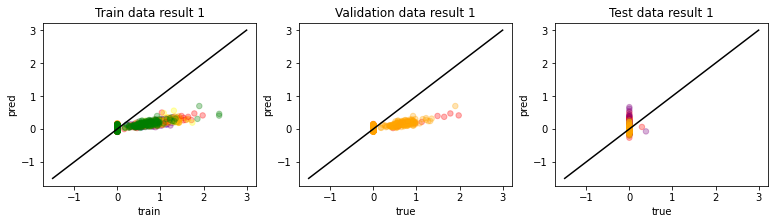

Epoch  16100 Train_loss:  0.086894765  Validation_loss:  0.09244793  Test_loss:  0.0877409
Epoch  16200 Train_loss:  0.08676387  Validation_loss:  0.092296936  Test_loss:  0.08795839
Epoch  16300 Train_loss:  0.08663214  Validation_loss:  0.092145205  Test_loss:  0.08820235
Epoch  16400 Train_loss:  0.08649968  Validation_loss:  0.09199274  Test_loss:  0.08842586
Epoch  16500 Train_loss:  0.086366676  Validation_loss:  0.091839895  Test_loss:  0.08869579
Epoch  16600 Train_loss:  0.08623338  Validation_loss:  0.09168636  Test_loss:  0.08894237
Epoch  16700 Train_loss:  0.08609925  Validation_loss:  0.091532245  Test_loss:  0.08919605
Epoch  16800 Train_loss:  0.085964635  Validation_loss:  0.0913776  Test_loss:  0.08941469
Epoch  16900 Train_loss:  0.085830115  Validation_loss:  0.09122261  Test_loss:  0.08966574
Epoch  17000 Train_loss:  0.08569413  Validation_loss:  0.091066964  Test_loss:  0.08988058


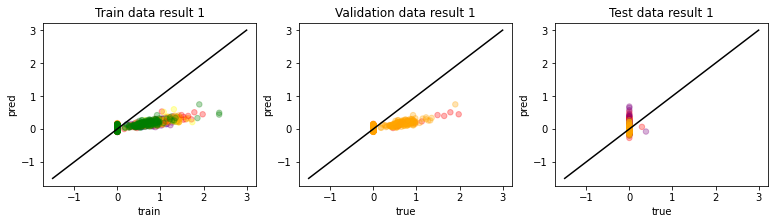

Epoch  17100 Train_loss:  0.08555809  Validation_loss:  0.09091085  Test_loss:  0.09011575
Epoch  17200 Train_loss:  0.08542139  Validation_loss:  0.090753585  Test_loss:  0.09037389
Epoch  17300 Train_loss:  0.085283935  Validation_loss:  0.0905961  Test_loss:  0.090605125
Epoch  17400 Train_loss:  0.085146286  Validation_loss:  0.0904374  Test_loss:  0.09083841
Epoch  17500 Train_loss:  0.08500769  Validation_loss:  0.09027869  Test_loss:  0.09107162
Epoch  17600 Train_loss:  0.08486888  Validation_loss:  0.090119176  Test_loss:  0.091346584
Epoch  17700 Train_loss:  0.08472945  Validation_loss:  0.089959055  Test_loss:  0.091584526
Epoch  17800 Train_loss:  0.08458912  Validation_loss:  0.08979839  Test_loss:  0.09181309
Epoch  17900 Train_loss:  0.08444831  Validation_loss:  0.0896371  Test_loss:  0.092034474
Epoch  18000 Train_loss:  0.08430739  Validation_loss:  0.08947603  Test_loss:  0.092268996


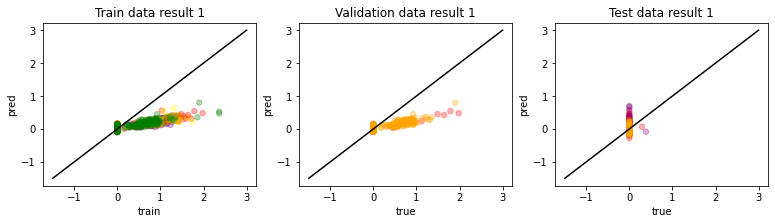

Epoch  18100 Train_loss:  0.084165715  Validation_loss:  0.08931341  Test_loss:  0.09253579
Epoch  18200 Train_loss:  0.08402368  Validation_loss:  0.08915056  Test_loss:  0.09279455
Epoch  18300 Train_loss:  0.083881326  Validation_loss:  0.088987365  Test_loss:  0.092997655
Epoch  18400 Train_loss:  0.083737805  Validation_loss:  0.08882347  Test_loss:  0.093236074
Epoch  18500 Train_loss:  0.083594516  Validation_loss:  0.08865893  Test_loss:  0.09352005
Epoch  18600 Train_loss:  0.0834499  Validation_loss:  0.08849406  Test_loss:  0.09375689
Epoch  18700 Train_loss:  0.08330511  Validation_loss:  0.08832809  Test_loss:  0.09403166
Epoch  18800 Train_loss:  0.0831593  Validation_loss:  0.08816183  Test_loss:  0.09430212
Epoch  18900 Train_loss:  0.08301345  Validation_loss:  0.08799563  Test_loss:  0.094503745
Epoch  19000 Train_loss:  0.08286698  Validation_loss:  0.08782788  Test_loss:  0.09474256


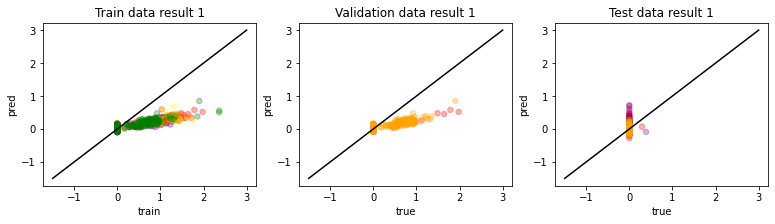

Epoch  19100 Train_loss:  0.08271996  Validation_loss:  0.087659895  Test_loss:  0.094994396
Epoch  19200 Train_loss:  0.08257243  Validation_loss:  0.08749132  Test_loss:  0.0952201
Epoch  19300 Train_loss:  0.08242418  Validation_loss:  0.08732241  Test_loss:  0.09546865
Epoch  19400 Train_loss:  0.0822757  Validation_loss:  0.08715294  Test_loss:  0.095715046
Epoch  19500 Train_loss:  0.08212667  Validation_loss:  0.086982384  Test_loss:  0.09598798
Epoch  19600 Train_loss:  0.08197731  Validation_loss:  0.086811475  Test_loss:  0.09620719
Epoch  19700 Train_loss:  0.081826635  Validation_loss:  0.08664026  Test_loss:  0.09646675
Epoch  19800 Train_loss:  0.08167639  Validation_loss:  0.08646886  Test_loss:  0.09666376
Epoch  19900 Train_loss:  0.08152541  Validation_loss:  0.08629636  Test_loss:  0.09691413
Epoch  20000 Train_loss:  0.08137298  Validation_loss:  0.08612291  Test_loss:  0.09718829


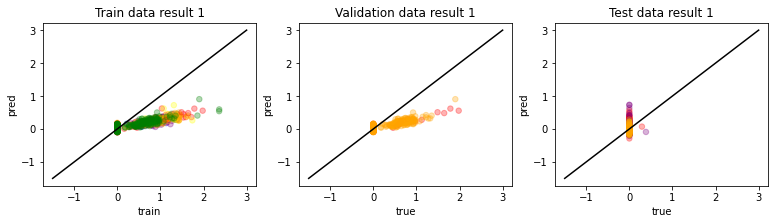

In [42]:
num_epochs = 20001
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

Epoch  0 Train_loss:  0.08137152  Validation_loss:  0.08612127  Test_loss:  0.09719163


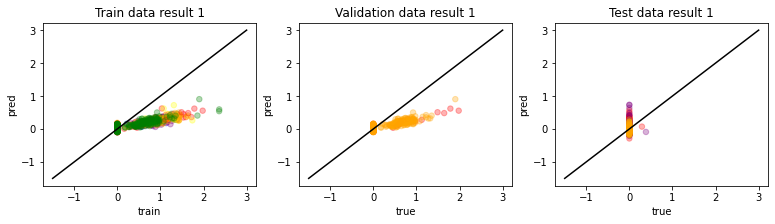

Epoch  100 Train_loss:  0.07995492  Validation_loss:  0.08450914  Test_loss:  0.099402495
Epoch  200 Train_loss:  0.07836468  Validation_loss:  0.08270323  Test_loss:  0.10183998
Epoch  300 Train_loss:  0.07672931  Validation_loss:  0.08084958  Test_loss:  0.10407125
Epoch  400 Train_loss:  0.07504938  Validation_loss:  0.07895107  Test_loss:  0.10661404
Epoch  500 Train_loss:  0.07333062  Validation_loss:  0.07701305  Test_loss:  0.10866072
Epoch  600 Train_loss:  0.07157646  Validation_loss:  0.07504183  Test_loss:  0.11081246
Epoch  700 Train_loss:  0.0697922  Validation_loss:  0.07303923  Test_loss:  0.11292509
Epoch  800 Train_loss:  0.06798327  Validation_loss:  0.0710156  Test_loss:  0.11482382
Epoch  900 Train_loss:  0.06615738  Validation_loss:  0.06897765  Test_loss:  0.1166948
Epoch  1000 Train_loss:  0.06432004  Validation_loss:  0.06693691  Test_loss:  0.118438095


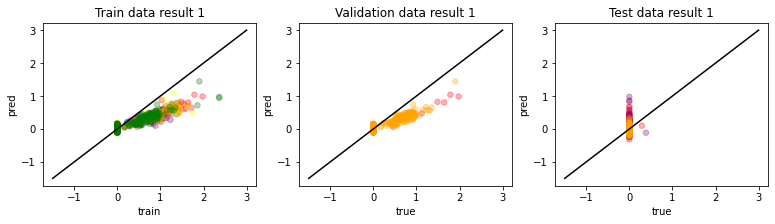

Epoch  1100 Train_loss:  0.06247492  Validation_loss:  0.06488585  Test_loss:  0.120391354
Epoch  1200 Train_loss:  0.060631864  Validation_loss:  0.06284126  Test_loss:  0.12194182
Epoch  1300 Train_loss:  0.05879527  Validation_loss:  0.060811203  Test_loss:  0.12347054
Epoch  1400 Train_loss:  0.056971617  Validation_loss:  0.0587988  Test_loss:  0.12500246
Epoch  1500 Train_loss:  0.055166606  Validation_loss:  0.056809712  Test_loss:  0.12626562
Epoch  1600 Train_loss:  0.053384155  Validation_loss:  0.05485526  Test_loss:  0.12743895
Epoch  1700 Train_loss:  0.051627044  Validation_loss:  0.052935433  Test_loss:  0.12870891
Epoch  1800 Train_loss:  0.0499072  Validation_loss:  0.051059797  Test_loss:  0.12975106
Epoch  1900 Train_loss:  0.0482214  Validation_loss:  0.049224764  Test_loss:  0.1306388
Epoch  2000 Train_loss:  0.046576474  Validation_loss:  0.047438398  Test_loss:  0.13216798


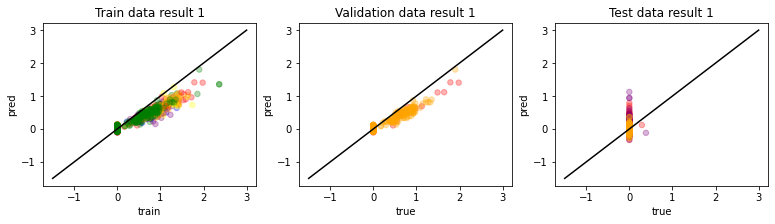

Epoch  2100 Train_loss:  0.044974517  Validation_loss:  0.045703355  Test_loss:  0.13297074
Epoch  2200 Train_loss:  0.04341661  Validation_loss:  0.044029642  Test_loss:  0.13382705
Epoch  2300 Train_loss:  0.0419069  Validation_loss:  0.04240371  Test_loss:  0.13415726
Epoch  2400 Train_loss:  0.040443946  Validation_loss:  0.04083994  Test_loss:  0.13491552
Epoch  2500 Train_loss:  0.039031252  Validation_loss:  0.03932397  Test_loss:  0.13546686
Epoch  2600 Train_loss:  0.037673645  Validation_loss:  0.037875604  Test_loss:  0.13599217
Epoch  2700 Train_loss:  0.03636263  Validation_loss:  0.03648323  Test_loss:  0.13649115
Epoch  2800 Train_loss:  0.035105474  Validation_loss:  0.03514507  Test_loss:  0.13671228
Epoch  2900 Train_loss:  0.03389462  Validation_loss:  0.03386732  Test_loss:  0.13685678
Epoch  3000 Train_loss:  0.03273487  Validation_loss:  0.032643106  Test_loss:  0.13732198


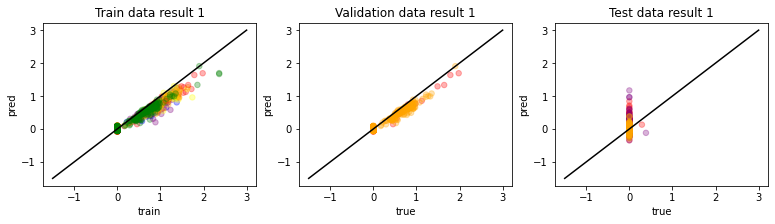

Epoch  3100 Train_loss:  0.031624593  Validation_loss:  0.031473096  Test_loss:  0.13761418
Epoch  3200 Train_loss:  0.030568073  Validation_loss:  0.030360747  Test_loss:  0.13775156
Epoch  3300 Train_loss:  0.029550724  Validation_loss:  0.029282585  Test_loss:  0.1381092
Epoch  3400 Train_loss:  0.028587028  Validation_loss:  0.028280117  Test_loss:  0.13789187
Epoch  3500 Train_loss:  0.027657906  Validation_loss:  0.02730687  Test_loss:  0.13806573
Epoch  3600 Train_loss:  0.026774583  Validation_loss:  0.026388744  Test_loss:  0.13841124
Epoch  3700 Train_loss:  0.025938764  Validation_loss:  0.02552432  Test_loss:  0.13837603
Epoch  3800 Train_loss:  0.025138777  Validation_loss:  0.02470412  Test_loss:  0.1385383
Epoch  3900 Train_loss:  0.024366291  Validation_loss:  0.023902984  Test_loss:  0.13856444
Epoch  4000 Train_loss:  0.023642214  Validation_loss:  0.023172434  Test_loss:  0.1383519


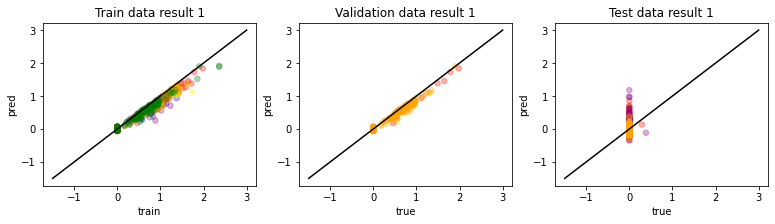

Epoch  4100 Train_loss:  0.022945203  Validation_loss:  0.022446292  Test_loss:  0.1387331
Epoch  4200 Train_loss:  0.022280687  Validation_loss:  0.021769319  Test_loss:  0.1384749
Epoch  4300 Train_loss:  0.021648007  Validation_loss:  0.021129327  Test_loss:  0.13808027
Epoch  4400 Train_loss:  0.021049427  Validation_loss:  0.020529814  Test_loss:  0.1377769
Epoch  4500 Train_loss:  0.02047428  Validation_loss:  0.019950809  Test_loss:  0.13785985
Epoch  4600 Train_loss:  0.019922646  Validation_loss:  0.01939345  Test_loss:  0.13763565
Epoch  4700 Train_loss:  0.019400856  Validation_loss:  0.018869188  Test_loss:  0.13783506
Epoch  4800 Train_loss:  0.01890356  Validation_loss:  0.018373013  Test_loss:  0.13800679
Epoch  4900 Train_loss:  0.018425342  Validation_loss:  0.017887183  Test_loss:  0.137892
Epoch  5000 Train_loss:  0.017976519  Validation_loss:  0.017447462  Test_loss:  0.13754033


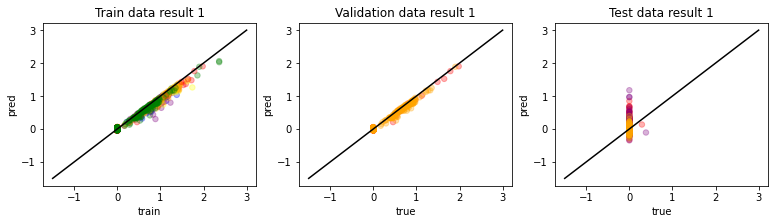

Epoch  5100 Train_loss:  0.017552529  Validation_loss:  0.017027913  Test_loss:  0.13778034
Epoch  5200 Train_loss:  0.017139254  Validation_loss:  0.016622286  Test_loss:  0.13736749
Epoch  5300 Train_loss:  0.016748326  Validation_loss:  0.016240718  Test_loss:  0.13730067
Epoch  5400 Train_loss:  0.016373906  Validation_loss:  0.015873674  Test_loss:  0.13742568
Epoch  5500 Train_loss:  0.016016576  Validation_loss:  0.015533088  Test_loss:  0.13715293
Epoch  5600 Train_loss:  0.015675377  Validation_loss:  0.015208533  Test_loss:  0.13708542
Epoch  5700 Train_loss:  0.01533769  Validation_loss:  0.014876127  Test_loss:  0.13701427
Epoch  5800 Train_loss:  0.015029491  Validation_loss:  0.014580545  Test_loss:  0.13726343
Epoch  5900 Train_loss:  0.014724349  Validation_loss:  0.014284577  Test_loss:  0.13714229
Epoch  6000 Train_loss:  0.014442772  Validation_loss:  0.0140241245  Test_loss:  0.13631284


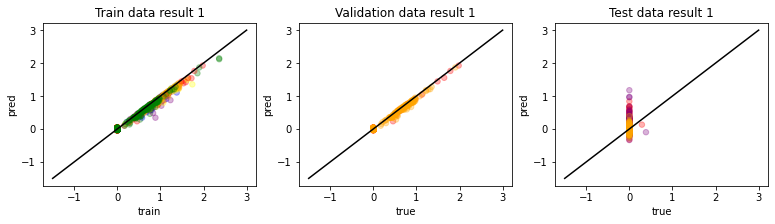

Epoch  6100 Train_loss:  0.014168544  Validation_loss:  0.013756154  Test_loss:  0.13642688
Epoch  6200 Train_loss:  0.013892186  Validation_loss:  0.013490072  Test_loss:  0.13613735
Epoch  6300 Train_loss:  0.013638018  Validation_loss:  0.0132483095  Test_loss:  0.13624622
Epoch  6400 Train_loss:  0.013394996  Validation_loss:  0.013019565  Test_loss:  0.13626078
Epoch  6500 Train_loss:  0.013160185  Validation_loss:  0.012791686  Test_loss:  0.13618486
Epoch  6600 Train_loss:  0.012935238  Validation_loss:  0.012578292  Test_loss:  0.1364252
Epoch  6700 Train_loss:  0.012714449  Validation_loss:  0.012372715  Test_loss:  0.13599014
Epoch  6800 Train_loss:  0.012509463  Validation_loss:  0.012188052  Test_loss:  0.1359351
Epoch  6900 Train_loss:  0.012316098  Validation_loss:  0.0120103285  Test_loss:  0.13572466
Epoch  7000 Train_loss:  0.01212234  Validation_loss:  0.011826816  Test_loss:  0.13545582


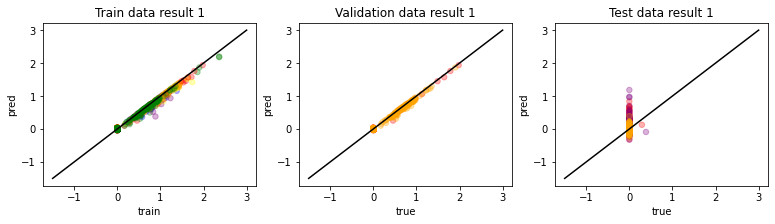

Epoch  7100 Train_loss:  0.011940677  Validation_loss:  0.011662489  Test_loss:  0.13537887
Epoch  7200 Train_loss:  0.011761594  Validation_loss:  0.011485546  Test_loss:  0.13567188
Epoch  7300 Train_loss:  0.011588986  Validation_loss:  0.0113324225  Test_loss:  0.13562022
Epoch  7400 Train_loss:  0.0114194425  Validation_loss:  0.011172857  Test_loss:  0.13557567
Epoch  7500 Train_loss:  0.011260177  Validation_loss:  0.011023893  Test_loss:  0.13521597
Epoch  7600 Train_loss:  0.011108429  Validation_loss:  0.0108846035  Test_loss:  0.13508664
Epoch  7700 Train_loss:  0.010952946  Validation_loss:  0.010744428  Test_loss:  0.1352221
Epoch  7800 Train_loss:  0.010809562  Validation_loss:  0.01061089  Test_loss:  0.13519421
Epoch  7900 Train_loss:  0.010661705  Validation_loss:  0.010478012  Test_loss:  0.13468994
Epoch  8000 Train_loss:  0.010521805  Validation_loss:  0.010351842  Test_loss:  0.13507852


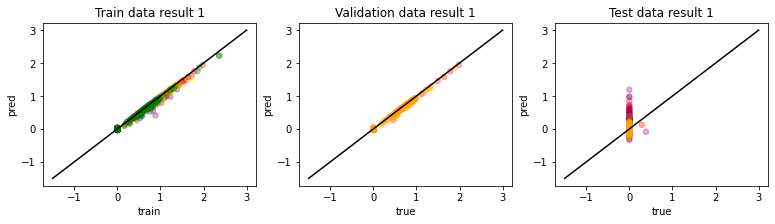

Epoch  8100 Train_loss:  0.010399744  Validation_loss:  0.010242816  Test_loss:  0.13451572
Epoch  8200 Train_loss:  0.0102679655  Validation_loss:  0.010124329  Test_loss:  0.13409905
Epoch  8300 Train_loss:  0.010145653  Validation_loss:  0.0100155715  Test_loss:  0.13451809
Epoch  8400 Train_loss:  0.010027077  Validation_loss:  0.009910453  Test_loss:  0.1341706
Epoch  8500 Train_loss:  0.00990798  Validation_loss:  0.009799184  Test_loss:  0.13415354
Epoch  8600 Train_loss:  0.00979747  Validation_loss:  0.009701103  Test_loss:  0.1340684
Epoch  8700 Train_loss:  0.0096880905  Validation_loss:  0.009600604  Test_loss:  0.13395113
Epoch  8800 Train_loss:  0.009577454  Validation_loss:  0.009496006  Test_loss:  0.13420561
Epoch  8900 Train_loss:  0.009480311  Validation_loss:  0.009405457  Test_loss:  0.1341841
Epoch  9000 Train_loss:  0.00938161  Validation_loss:  0.009308892  Test_loss:  0.13418743


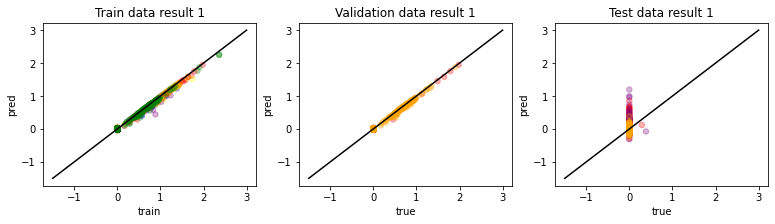

Epoch  9100 Train_loss:  0.009276637  Validation_loss:  0.009215158  Test_loss:  0.13431059
Epoch  9200 Train_loss:  0.009179143  Validation_loss:  0.009122764  Test_loss:  0.13433936
Epoch  9300 Train_loss:  0.009089129  Validation_loss:  0.009043976  Test_loss:  0.1342375
Epoch  9400 Train_loss:  0.009007744  Validation_loss:  0.008977423  Test_loss:  0.13320516
Epoch  9500 Train_loss:  0.0089201  Validation_loss:  0.008889632  Test_loss:  0.13362868
Epoch  9600 Train_loss:  0.008831538  Validation_loss:  0.00881247  Test_loss:  0.13362947
Epoch  9700 Train_loss:  0.008746505  Validation_loss:  0.008729174  Test_loss:  0.13380642
Epoch  9800 Train_loss:  0.008665313  Validation_loss:  0.008652973  Test_loss:  0.1333555
Epoch  9900 Train_loss:  0.008588925  Validation_loss:  0.008587151  Test_loss:  0.13294384
Epoch  10000 Train_loss:  0.008505056  Validation_loss:  0.008506349  Test_loss:  0.13316388


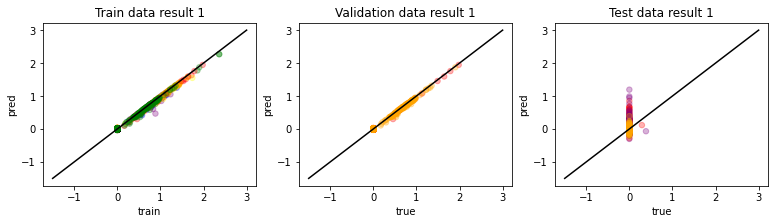

Epoch  10100 Train_loss:  0.008428273  Validation_loss:  0.008430728  Test_loss:  0.13324548
Epoch  10200 Train_loss:  0.008345096  Validation_loss:  0.008350969  Test_loss:  0.13371275
Epoch  10300 Train_loss:  0.00827849  Validation_loss:  0.008289443  Test_loss:  0.13317569
Epoch  10400 Train_loss:  0.008213708  Validation_loss:  0.008237885  Test_loss:  0.13315669
Epoch  10500 Train_loss:  0.008138498  Validation_loss:  0.008168146  Test_loss:  0.13287446
Epoch  10600 Train_loss:  0.008072438  Validation_loss:  0.008107001  Test_loss:  0.13261841
Epoch  10700 Train_loss:  0.00801977  Validation_loss:  0.008067034  Test_loss:  0.1329056
Epoch  10800 Train_loss:  0.007952022  Validation_loss:  0.007995759  Test_loss:  0.1328206
Epoch  10900 Train_loss:  0.007888086  Validation_loss:  0.007932975  Test_loss:  0.1330175
Epoch  11000 Train_loss:  0.007834853  Validation_loss:  0.007882378  Test_loss:  0.13257264


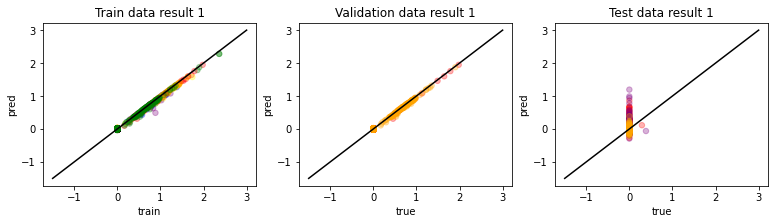

Epoch  11100 Train_loss:  0.007775345  Validation_loss:  0.007826754  Test_loss:  0.13282517
Epoch  11200 Train_loss:  0.007714045  Validation_loss:  0.007768455  Test_loss:  0.13275795
Epoch  11300 Train_loss:  0.007648836  Validation_loss:  0.0077072224  Test_loss:  0.13245115
Epoch  11400 Train_loss:  0.0075851777  Validation_loss:  0.0076387525  Test_loss:  0.13314115
Epoch  11500 Train_loss:  0.0075350055  Validation_loss:  0.007598291  Test_loss:  0.13283794
Epoch  11600 Train_loss:  0.007492343  Validation_loss:  0.007564161  Test_loss:  0.13282095
Epoch  11700 Train_loss:  0.0074397745  Validation_loss:  0.0075156307  Test_loss:  0.1324004
Epoch  11800 Train_loss:  0.0073704096  Validation_loss:  0.007442837  Test_loss:  0.13300353
Epoch  11900 Train_loss:  0.0073246714  Validation_loss:  0.007409033  Test_loss:  0.13253143
Epoch  12000 Train_loss:  0.007263199  Validation_loss:  0.007347809  Test_loss:  0.132661


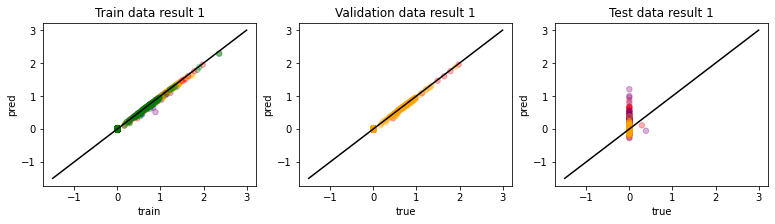

Epoch  12100 Train_loss:  0.007220335  Validation_loss:  0.0073131775  Test_loss:  0.13247861
Epoch  12200 Train_loss:  0.0071727796  Validation_loss:  0.007278569  Test_loss:  0.13215661
Epoch  12300 Train_loss:  0.0071334536  Validation_loss:  0.00723583  Test_loss:  0.13200134
Epoch  12400 Train_loss:  0.00708454  Validation_loss:  0.007186927  Test_loss:  0.13193242
Epoch  12500 Train_loss:  0.007027297  Validation_loss:  0.007130775  Test_loss:  0.13187884
Epoch  12600 Train_loss:  0.00697286  Validation_loss:  0.007076258  Test_loss:  0.13203688
Epoch  12700 Train_loss:  0.006933221  Validation_loss:  0.0070407917  Test_loss:  0.13211139
Epoch  12800 Train_loss:  0.0068798847  Validation_loss:  0.006985793  Test_loss:  0.1317968
Epoch  12900 Train_loss:  0.006850835  Validation_loss:  0.0069604698  Test_loss:  0.13164742
Epoch  13000 Train_loss:  0.0068092444  Validation_loss:  0.006919025  Test_loss:  0.13183533


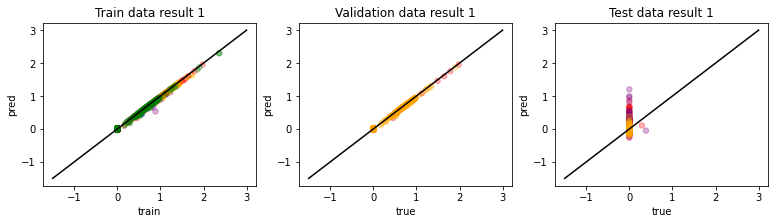

Epoch  13100 Train_loss:  0.006763123  Validation_loss:  0.0068697054  Test_loss:  0.13178232
Epoch  13200 Train_loss:  0.0067279693  Validation_loss:  0.006839192  Test_loss:  0.13164923
Epoch  13300 Train_loss:  0.0066933497  Validation_loss:  0.0068078954  Test_loss:  0.13155425
Epoch  13400 Train_loss:  0.006650526  Validation_loss:  0.0067687654  Test_loss:  0.13172653
Epoch  13500 Train_loss:  0.0065986956  Validation_loss:  0.0067148865  Test_loss:  0.13145004
Epoch  13600 Train_loss:  0.0065701944  Validation_loss:  0.00670464  Test_loss:  0.13125928
Epoch  13700 Train_loss:  0.0065325834  Validation_loss:  0.0066631683  Test_loss:  0.13153078
Epoch  13800 Train_loss:  0.00649276  Validation_loss:  0.006620791  Test_loss:  0.13152784
Epoch  13900 Train_loss:  0.006454353  Validation_loss:  0.0065798904  Test_loss:  0.13154635
Epoch  14000 Train_loss:  0.006427336  Validation_loss:  0.006556027  Test_loss:  0.13120955


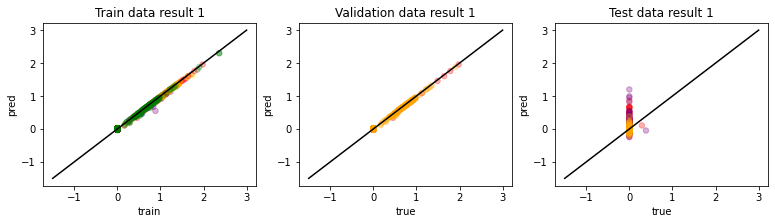

Epoch  14100 Train_loss:  0.0063746152  Validation_loss:  0.0064988653  Test_loss:  0.1314544
Epoch  14200 Train_loss:  0.0063285925  Validation_loss:  0.0064533893  Test_loss:  0.13141438
Epoch  14300 Train_loss:  0.0063060513  Validation_loss:  0.0064343885  Test_loss:  0.13116923
Epoch  14400 Train_loss:  0.0062683676  Validation_loss:  0.0063973805  Test_loss:  0.13131016
Epoch  14500 Train_loss:  0.0062437197  Validation_loss:  0.0063776975  Test_loss:  0.13102214
Epoch  14600 Train_loss:  0.0062226937  Validation_loss:  0.006366905  Test_loss:  0.13086799
Epoch  14700 Train_loss:  0.0061768293  Validation_loss:  0.0063117617  Test_loss:  0.13099751
Epoch  14800 Train_loss:  0.00615292  Validation_loss:  0.0063023674  Test_loss:  0.13041463
Epoch  14900 Train_loss:  0.0061193784  Validation_loss:  0.0062633227  Test_loss:  0.13086006
Epoch  15000 Train_loss:  0.0060782824  Validation_loss:  0.006223025  Test_loss:  0.13068645


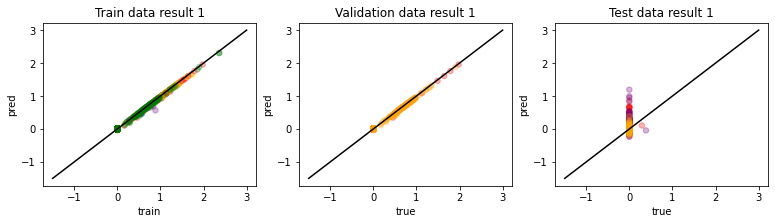

Epoch  15100 Train_loss:  0.0060485466  Validation_loss:  0.0061947843  Test_loss:  0.1308883
Epoch  15200 Train_loss:  0.0060155676  Validation_loss:  0.006150045  Test_loss:  0.13127105
Epoch  15300 Train_loss:  0.0059844637  Validation_loss:  0.006111627  Test_loss:  0.13133456
Epoch  15400 Train_loss:  0.0059465347  Validation_loss:  0.006079356  Test_loss:  0.13098684
Epoch  15500 Train_loss:  0.0059259287  Validation_loss:  0.006056001  Test_loss:  0.13060853
Epoch  15600 Train_loss:  0.0058983397  Validation_loss:  0.006023001  Test_loss:  0.13055776
Epoch  15700 Train_loss:  0.0058559603  Validation_loss:  0.005969585  Test_loss:  0.13106418
Epoch  15800 Train_loss:  0.0058516283  Validation_loss:  0.005975264  Test_loss:  0.13046038
Epoch  15900 Train_loss:  0.005810356  Validation_loss:  0.0059316657  Test_loss:  0.13042302
Epoch  16000 Train_loss:  0.005779098  Validation_loss:  0.005900857  Test_loss:  0.13029684


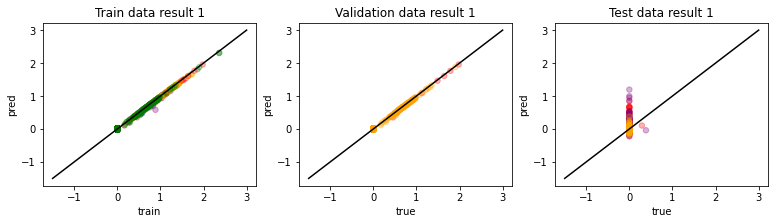

Epoch  16100 Train_loss:  0.0057604644  Validation_loss:  0.005883405  Test_loss:  0.13060807
Epoch  16200 Train_loss:  0.005731384  Validation_loss:  0.005858156  Test_loss:  0.13041528
Epoch  16300 Train_loss:  0.0057108453  Validation_loss:  0.005845081  Test_loss:  0.1302842
Epoch  16400 Train_loss:  0.0056614685  Validation_loss:  0.0057929982  Test_loss:  0.13070442
Epoch  16500 Train_loss:  0.0056427843  Validation_loss:  0.005770119  Test_loss:  0.13105474
Epoch  16600 Train_loss:  0.0056439037  Validation_loss:  0.005777832  Test_loss:  0.13056415
Epoch  16700 Train_loss:  0.005607242  Validation_loss:  0.005731989  Test_loss:  0.13036403
Epoch  16800 Train_loss:  0.0055756383  Validation_loss:  0.0057027927  Test_loss:  0.13038315
Epoch  16900 Train_loss:  0.0055423984  Validation_loss:  0.005670408  Test_loss:  0.13073964
Epoch  17000 Train_loss:  0.0055217417  Validation_loss:  0.005649829  Test_loss:  0.13049759


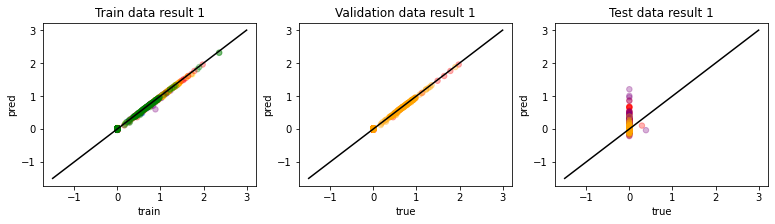

Epoch  17100 Train_loss:  0.005500487  Validation_loss:  0.0056257704  Test_loss:  0.13025759
Epoch  17200 Train_loss:  0.005483104  Validation_loss:  0.0056101237  Test_loss:  0.13035612
Epoch  17300 Train_loss:  0.0054535903  Validation_loss:  0.0055866167  Test_loss:  0.13014911
Epoch  17400 Train_loss:  0.005441289  Validation_loss:  0.005581601  Test_loss:  0.13010056
Epoch  17500 Train_loss:  0.005403099  Validation_loss:  0.005540258  Test_loss:  0.13038369
Epoch  17600 Train_loss:  0.00537813  Validation_loss:  0.0055097737  Test_loss:  0.13054541
Epoch  17700 Train_loss:  0.0053502843  Validation_loss:  0.005473369  Test_loss:  0.13032788
Epoch  17800 Train_loss:  0.005315682  Validation_loss:  0.0054363003  Test_loss:  0.13039283
Epoch  17900 Train_loss:  0.005312273  Validation_loss:  0.005440947  Test_loss:  0.13007227
Epoch  18000 Train_loss:  0.0052869334  Validation_loss:  0.0054239715  Test_loss:  0.13005932


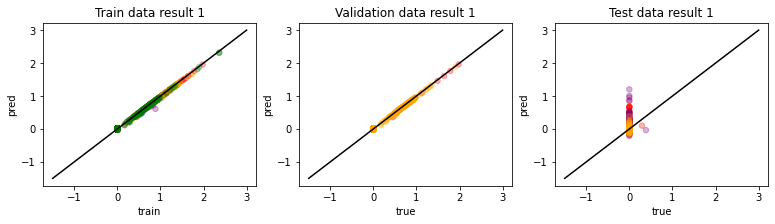

Epoch  18100 Train_loss:  0.005249468  Validation_loss:  0.0053832084  Test_loss:  0.1306112
Epoch  18200 Train_loss:  0.005225505  Validation_loss:  0.0053655165  Test_loss:  0.130246
Epoch  18300 Train_loss:  0.005199672  Validation_loss:  0.005330962  Test_loss:  0.13021633
Epoch  18400 Train_loss:  0.005203183  Validation_loss:  0.005346022  Test_loss:  0.12967227
Epoch  18500 Train_loss:  0.0051808585  Validation_loss:  0.0053158933  Test_loss:  0.13014187
Epoch  18600 Train_loss:  0.0051565976  Validation_loss:  0.005297711  Test_loss:  0.12989873
Epoch  18700 Train_loss:  0.005116762  Validation_loss:  0.005245699  Test_loss:  0.13018064
Epoch  18800 Train_loss:  0.0051095965  Validation_loss:  0.0052461904  Test_loss:  0.13004448
Epoch  18900 Train_loss:  0.005096374  Validation_loss:  0.005229963  Test_loss:  0.1298773
Epoch  19000 Train_loss:  0.0050802473  Validation_loss:  0.0052177473  Test_loss:  0.12988158


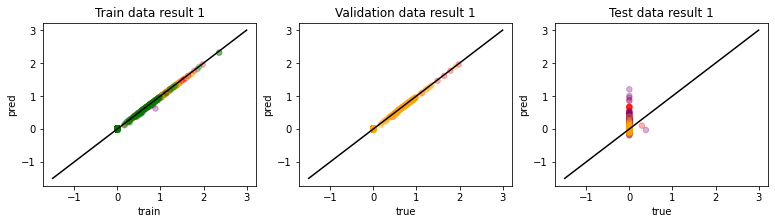

Epoch  19100 Train_loss:  0.0050436663  Validation_loss:  0.0051815235  Test_loss:  0.1301869
Epoch  19200 Train_loss:  0.00503187  Validation_loss:  0.0051762373  Test_loss:  0.13006434
Epoch  19300 Train_loss:  0.005010315  Validation_loss:  0.005151553  Test_loss:  0.12979826
Epoch  19400 Train_loss:  0.0049835946  Validation_loss:  0.0051246774  Test_loss:  0.12985449
Epoch  19500 Train_loss:  0.004974486  Validation_loss:  0.0051174015  Test_loss:  0.12966304
Epoch  19600 Train_loss:  0.00495052  Validation_loss:  0.005086476  Test_loss:  0.12963651
Epoch  19700 Train_loss:  0.004921623  Validation_loss:  0.005051902  Test_loss:  0.1297014
Epoch  19800 Train_loss:  0.0049011963  Validation_loss:  0.0050367624  Test_loss:  0.12941366
Epoch  19900 Train_loss:  0.004909112  Validation_loss:  0.0050485954  Test_loss:  0.12940967
Epoch  20000 Train_loss:  0.004873952  Validation_loss:  0.005005259  Test_loss:  0.12972464


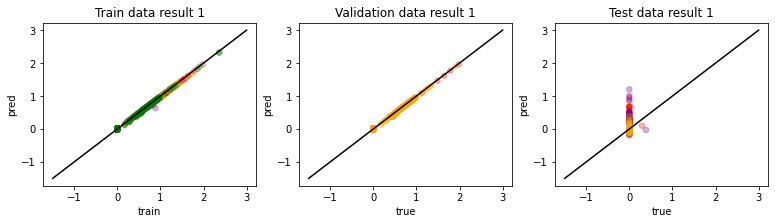

Epoch  20100 Train_loss:  0.0048415842  Validation_loss:  0.004967313  Test_loss:  0.12975913
Epoch  20200 Train_loss:  0.0048483354  Validation_loss:  0.00499146  Test_loss:  0.12928835
Epoch  20300 Train_loss:  0.0048323628  Validation_loss:  0.0049692527  Test_loss:  0.12982681
Epoch  20400 Train_loss:  0.004802314  Validation_loss:  0.0049352557  Test_loss:  0.12967697
Epoch  20500 Train_loss:  0.004788474  Validation_loss:  0.004918298  Test_loss:  0.1301048
Epoch  20600 Train_loss:  0.0047685686  Validation_loss:  0.004893124  Test_loss:  0.12944843
Epoch  20700 Train_loss:  0.00474257  Validation_loss:  0.0048627476  Test_loss:  0.12995678
Epoch  20800 Train_loss:  0.0047322907  Validation_loss:  0.004857624  Test_loss:  0.12986685
Epoch  20900 Train_loss:  0.00472125  Validation_loss:  0.004848287  Test_loss:  0.12944707
Epoch  21000 Train_loss:  0.0046972977  Validation_loss:  0.004825834  Test_loss:  0.1292664


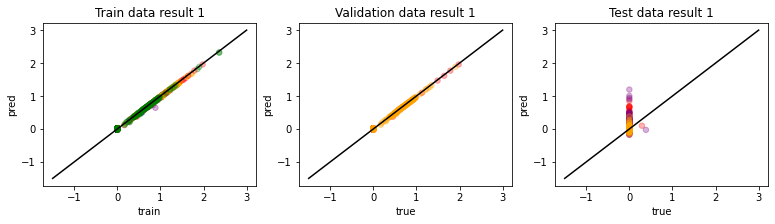

Epoch  21100 Train_loss:  0.004677807  Validation_loss:  0.0047999695  Test_loss:  0.12972936
Epoch  21200 Train_loss:  0.004666005  Validation_loss:  0.00479407  Test_loss:  0.12986499
Epoch  21300 Train_loss:  0.004639347  Validation_loss:  0.004754834  Test_loss:  0.129585
Epoch  21400 Train_loss:  0.004636192  Validation_loss:  0.0047569023  Test_loss:  0.12943508
Epoch  21500 Train_loss:  0.0046244115  Validation_loss:  0.0047515566  Test_loss:  0.12946585
Epoch  21600 Train_loss:  0.004608341  Validation_loss:  0.0047379658  Test_loss:  0.12942486
Epoch  21700 Train_loss:  0.0045878543  Validation_loss:  0.0047175325  Test_loss:  0.12970953
Epoch  21800 Train_loss:  0.004581479  Validation_loss:  0.0047150124  Test_loss:  0.12929447
Epoch  21900 Train_loss:  0.004557222  Validation_loss:  0.004685661  Test_loss:  0.12950873
Epoch  22000 Train_loss:  0.0045470875  Validation_loss:  0.0046693855  Test_loss:  0.12940253


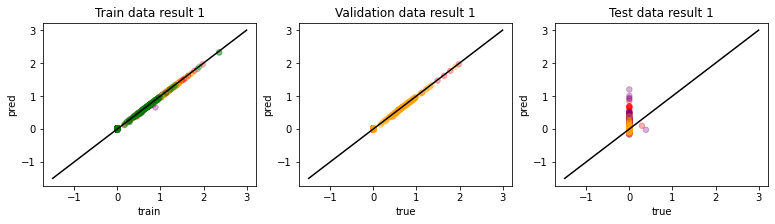

Epoch  22100 Train_loss:  0.004519331  Validation_loss:  0.004639243  Test_loss:  0.12938216
Epoch  22200 Train_loss:  0.0044977125  Validation_loss:  0.0046191793  Test_loss:  0.1297143
Epoch  22300 Train_loss:  0.004497084  Validation_loss:  0.0046187895  Test_loss:  0.12918958
Epoch  22400 Train_loss:  0.0044779186  Validation_loss:  0.0046032653  Test_loss:  0.12920879
Epoch  22500 Train_loss:  0.0044772075  Validation_loss:  0.0046061915  Test_loss:  0.12872925
Epoch  22600 Train_loss:  0.0044591567  Validation_loss:  0.004590145  Test_loss:  0.12925225
Epoch  22700 Train_loss:  0.00444911  Validation_loss:  0.004576966  Test_loss:  0.12898137
Epoch  22800 Train_loss:  0.004427067  Validation_loss:  0.0045521255  Test_loss:  0.12922631
Epoch  22900 Train_loss:  0.0044102347  Validation_loss:  0.004534205  Test_loss:  0.12921102
Epoch  23000 Train_loss:  0.004391115  Validation_loss:  0.0045137024  Test_loss:  0.1291267


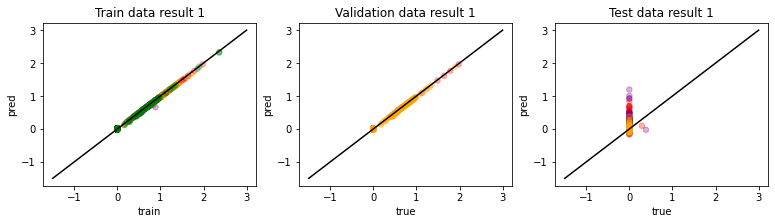

Epoch  23100 Train_loss:  0.0043838937  Validation_loss:  0.0045119645  Test_loss:  0.12900354
Epoch  23200 Train_loss:  0.004345099  Validation_loss:  0.0044603334  Test_loss:  0.12935472
Epoch  23300 Train_loss:  0.0043693823  Validation_loss:  0.0045001917  Test_loss:  0.12899514
Epoch  23400 Train_loss:  0.004353825  Validation_loss:  0.0044809654  Test_loss:  0.12910336
Epoch  23500 Train_loss:  0.0043144026  Validation_loss:  0.004430245  Test_loss:  0.12906237
Epoch  23600 Train_loss:  0.004310662  Validation_loss:  0.0044272062  Test_loss:  0.12901588
Epoch  23700 Train_loss:  0.0042852857  Validation_loss:  0.0043984773  Test_loss:  0.12934962
Epoch  23800 Train_loss:  0.004269914  Validation_loss:  0.004386261  Test_loss:  0.12897266
Epoch  23900 Train_loss:  0.004257746  Validation_loss:  0.0043823677  Test_loss:  0.12884761
Epoch  24000 Train_loss:  0.0042511956  Validation_loss:  0.0043687224  Test_loss:  0.12889637


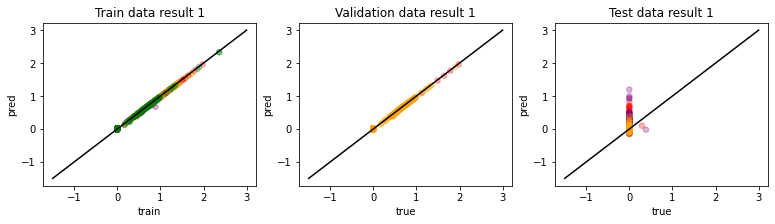

Epoch  24100 Train_loss:  0.0042176377  Validation_loss:  0.0043340498  Test_loss:  0.12937841
Epoch  24200 Train_loss:  0.0042142416  Validation_loss:  0.0043311752  Test_loss:  0.1291932
Epoch  24300 Train_loss:  0.0042081736  Validation_loss:  0.0043285256  Test_loss:  0.12886575
Epoch  24400 Train_loss:  0.0041836803  Validation_loss:  0.004302954  Test_loss:  0.12916641
Epoch  24500 Train_loss:  0.004180353  Validation_loss:  0.004308414  Test_loss:  0.12891978
Epoch  24600 Train_loss:  0.0041646324  Validation_loss:  0.0042883116  Test_loss:  0.12900881
Epoch  24700 Train_loss:  0.004156258  Validation_loss:  0.004285395  Test_loss:  0.12901124
Epoch  24800 Train_loss:  0.0041366145  Validation_loss:  0.0042587793  Test_loss:  0.12900828
Epoch  24900 Train_loss:  0.0041308487  Validation_loss:  0.004247819  Test_loss:  0.12895049
Epoch  25000 Train_loss:  0.0041140714  Validation_loss:  0.0042324793  Test_loss:  0.12871401


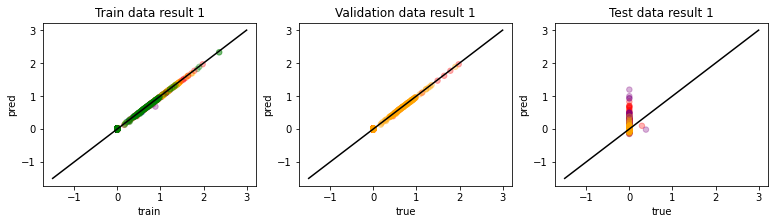

Epoch  25100 Train_loss:  0.00409114  Validation_loss:  0.004214017  Test_loss:  0.12892593
Epoch  25200 Train_loss:  0.0040929737  Validation_loss:  0.004214753  Test_loss:  0.1288464
Epoch  25300 Train_loss:  0.004078279  Validation_loss:  0.00420083  Test_loss:  0.12883592
Epoch  25400 Train_loss:  0.0040543503  Validation_loss:  0.004172237  Test_loss:  0.129133
Epoch  25500 Train_loss:  0.00404218  Validation_loss:  0.004158755  Test_loss:  0.1289105
Epoch  25600 Train_loss:  0.00403037  Validation_loss:  0.004148983  Test_loss:  0.12908892
Epoch  25700 Train_loss:  0.0040214667  Validation_loss:  0.0041372483  Test_loss:  0.12884194
Epoch  25800 Train_loss:  0.0040254667  Validation_loss:  0.0041440227  Test_loss:  0.12881517
Epoch  25900 Train_loss:  0.0040022633  Validation_loss:  0.004117847  Test_loss:  0.1289993
Epoch  26000 Train_loss:  0.0039808247  Validation_loss:  0.0040891324  Test_loss:  0.12905118


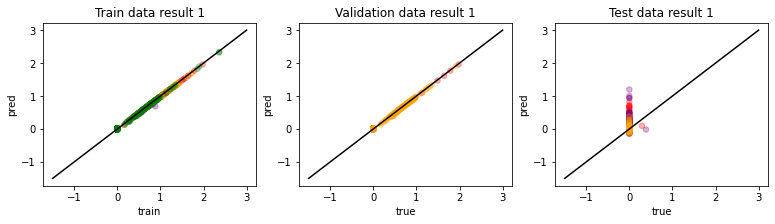

Epoch  26100 Train_loss:  0.003980076  Validation_loss:  0.004086726  Test_loss:  0.12886187
Epoch  26200 Train_loss:  0.003979708  Validation_loss:  0.0040911036  Test_loss:  0.12882066
Epoch  26300 Train_loss:  0.003957398  Validation_loss:  0.0040663686  Test_loss:  0.12919661
Epoch  26400 Train_loss:  0.003950881  Validation_loss:  0.004063957  Test_loss:  0.12902774
Epoch  26500 Train_loss:  0.0039414545  Validation_loss:  0.0040557194  Test_loss:  0.12890555
Epoch  26600 Train_loss:  0.0039308625  Validation_loss:  0.0040597413  Test_loss:  0.12905803
Epoch  26700 Train_loss:  0.003910687  Validation_loss:  0.0040441733  Test_loss:  0.1290208
Epoch  26800 Train_loss:  0.0038991147  Validation_loss:  0.0040280796  Test_loss:  0.12888438
Epoch  26900 Train_loss:  0.0038900252  Validation_loss:  0.004022235  Test_loss:  0.12868015
Epoch  27000 Train_loss:  0.0038670462  Validation_loss:  0.003990081  Test_loss:  0.1291176


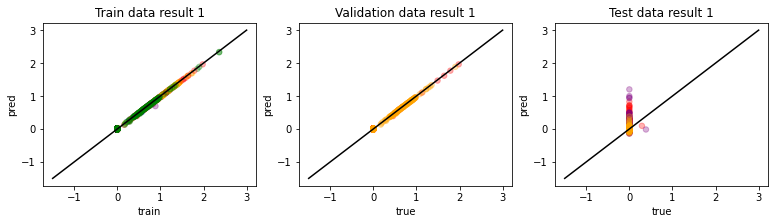

Epoch  27100 Train_loss:  0.0038893893  Validation_loss:  0.0040177875  Test_loss:  0.12834248
Epoch  27200 Train_loss:  0.003861781  Validation_loss:  0.0039879465  Test_loss:  0.12885095
Epoch  27300 Train_loss:  0.003820981  Validation_loss:  0.003938379  Test_loss:  0.12911156
Epoch  27400 Train_loss:  0.0038413259  Validation_loss:  0.0039724377  Test_loss:  0.12862119
Epoch  27500 Train_loss:  0.0038107536  Validation_loss:  0.003933361  Test_loss:  0.12904806
Epoch  27600 Train_loss:  0.003806814  Validation_loss:  0.0039300886  Test_loss:  0.12913465
Epoch  27700 Train_loss:  0.003809537  Validation_loss:  0.0039262604  Test_loss:  0.12876719
Epoch  27800 Train_loss:  0.00380156  Validation_loss:  0.003916763  Test_loss:  0.1287851
Epoch  27900 Train_loss:  0.0037955965  Validation_loss:  0.003911688  Test_loss:  0.12864465
Epoch  28000 Train_loss:  0.0037732318  Validation_loss:  0.003885621  Test_loss:  0.12893194


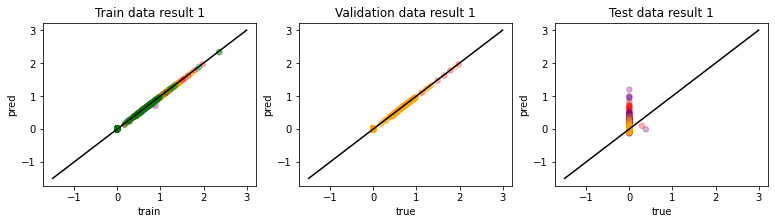

Epoch  28100 Train_loss:  0.0037659188  Validation_loss:  0.003877838  Test_loss:  0.12889509
Epoch  28200 Train_loss:  0.0037513652  Validation_loss:  0.0038652625  Test_loss:  0.12890282
Epoch  28300 Train_loss:  0.0037539217  Validation_loss:  0.0038654604  Test_loss:  0.12874076
Epoch  28400 Train_loss:  0.0037369814  Validation_loss:  0.0038472847  Test_loss:  0.12894922
Epoch  28500 Train_loss:  0.0037236814  Validation_loss:  0.003837577  Test_loss:  0.1289172
Epoch  28600 Train_loss:  0.00373456  Validation_loss:  0.0038520778  Test_loss:  0.12876493
Epoch  28700 Train_loss:  0.0037247587  Validation_loss:  0.003840666  Test_loss:  0.12908553
Epoch  28800 Train_loss:  0.0037062275  Validation_loss:  0.0038250766  Test_loss:  0.12911792
Epoch  28900 Train_loss:  0.0037012824  Validation_loss:  0.0038126104  Test_loss:  0.12891586
Epoch  29000 Train_loss:  0.0036984822  Validation_loss:  0.0038179073  Test_loss:  0.12890828


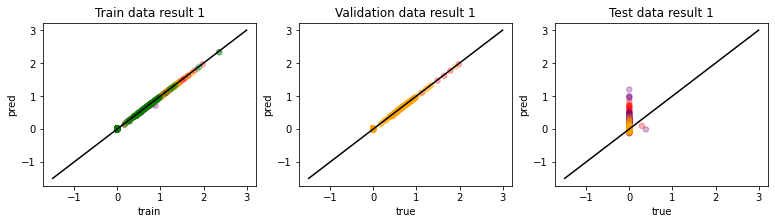

Epoch  29100 Train_loss:  0.0036877089  Validation_loss:  0.0037999956  Test_loss:  0.12911582
Epoch  29200 Train_loss:  0.003666828  Validation_loss:  0.0037764246  Test_loss:  0.12910804
Epoch  29300 Train_loss:  0.0036469835  Validation_loss:  0.0037537753  Test_loss:  0.12919359
Epoch  29400 Train_loss:  0.003639743  Validation_loss:  0.00374414  Test_loss:  0.12892523
Epoch  29500 Train_loss:  0.0036296959  Validation_loss:  0.0037322177  Test_loss:  0.12889624
Epoch  29600 Train_loss:  0.0036287834  Validation_loss:  0.0037326762  Test_loss:  0.12865576
Epoch  29700 Train_loss:  0.0036138706  Validation_loss:  0.0037150655  Test_loss:  0.12891603
Epoch  29800 Train_loss:  0.0035860618  Validation_loss:  0.0036836897  Test_loss:  0.12887307
Epoch  29900 Train_loss:  0.0036026004  Validation_loss:  0.0037133018  Test_loss:  0.1284755
Epoch  30000 Train_loss:  0.0036108368  Validation_loss:  0.0037129929  Test_loss:  0.12844853


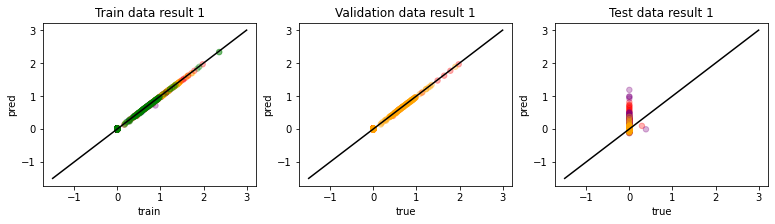

Epoch  30100 Train_loss:  0.0035945198  Validation_loss:  0.0037001758  Test_loss:  0.12858005
Epoch  30200 Train_loss:  0.0035792165  Validation_loss:  0.0036800583  Test_loss:  0.12870468
Epoch  30300 Train_loss:  0.0035983021  Validation_loss:  0.0037092008  Test_loss:  0.12838072
Epoch  30400 Train_loss:  0.0035669196  Validation_loss:  0.0036713341  Test_loss:  0.1285234
Epoch  30500 Train_loss:  0.0035610644  Validation_loss:  0.003671717  Test_loss:  0.12885235
Epoch  30600 Train_loss:  0.003544832  Validation_loss:  0.0036496262  Test_loss:  0.12852144
Epoch  30700 Train_loss:  0.0035152573  Validation_loss:  0.0036134631  Test_loss:  0.12885183
Epoch  30800 Train_loss:  0.0035027189  Validation_loss:  0.0036033595  Test_loss:  0.1286895
Epoch  30900 Train_loss:  0.0035019892  Validation_loss:  0.0036083376  Test_loss:  0.12850158
Epoch  31000 Train_loss:  0.0034735554  Validation_loss:  0.0035757269  Test_loss:  0.12895718


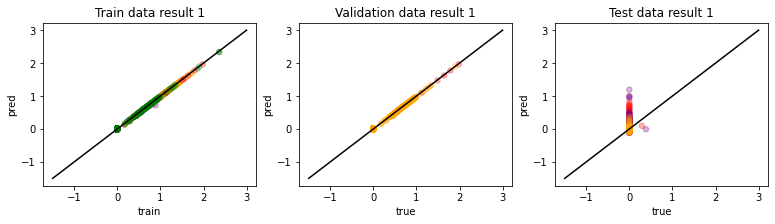

Epoch  31100 Train_loss:  0.0034846852  Validation_loss:  0.0035895107  Test_loss:  0.12854333
Epoch  31200 Train_loss:  0.003483862  Validation_loss:  0.003591742  Test_loss:  0.12894884
Epoch  31300 Train_loss:  0.0034818966  Validation_loss:  0.0035993143  Test_loss:  0.12877944
Epoch  31400 Train_loss:  0.0034832389  Validation_loss:  0.0035965801  Test_loss:  0.12869182
Epoch  31500 Train_loss:  0.0034527474  Validation_loss:  0.0035512326  Test_loss:  0.12863234
Epoch  31600 Train_loss:  0.0034420178  Validation_loss:  0.0035453283  Test_loss:  0.12857752
Epoch  31700 Train_loss:  0.0034428807  Validation_loss:  0.003543335  Test_loss:  0.1288464
Epoch  31800 Train_loss:  0.003421016  Validation_loss:  0.0035200291  Test_loss:  0.12843534
Epoch  31900 Train_loss:  0.0034002601  Validation_loss:  0.0034974734  Test_loss:  0.1289371
Epoch  32000 Train_loss:  0.0033890333  Validation_loss:  0.0034838063  Test_loss:  0.12897767


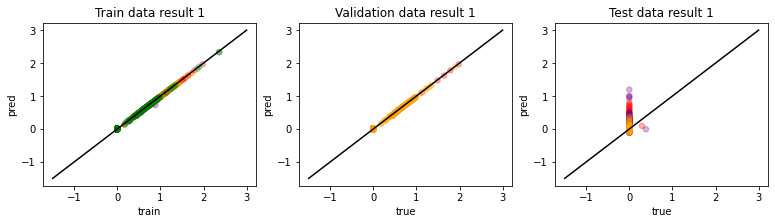

Epoch  32100 Train_loss:  0.0034083887  Validation_loss:  0.003511402  Test_loss:  0.12893975
Epoch  32200 Train_loss:  0.0034058683  Validation_loss:  0.003512814  Test_loss:  0.1286875
Epoch  32300 Train_loss:  0.003381023  Validation_loss:  0.0034840996  Test_loss:  0.12865879
Epoch  32400 Train_loss:  0.0033754562  Validation_loss:  0.0034837706  Test_loss:  0.12887326
Epoch  32500 Train_loss:  0.0033791733  Validation_loss:  0.0034857562  Test_loss:  0.12867886
Epoch  32600 Train_loss:  0.0033661686  Validation_loss:  0.0034756288  Test_loss:  0.12856145
Epoch  32700 Train_loss:  0.0033569492  Validation_loss:  0.0034732057  Test_loss:  0.12850659
Epoch  32800 Train_loss:  0.0033553867  Validation_loss:  0.0034668818  Test_loss:  0.12853864
Epoch  32900 Train_loss:  0.0033506555  Validation_loss:  0.0034652862  Test_loss:  0.1285902
Epoch  33000 Train_loss:  0.003343357  Validation_loss:  0.0034605106  Test_loss:  0.12843508


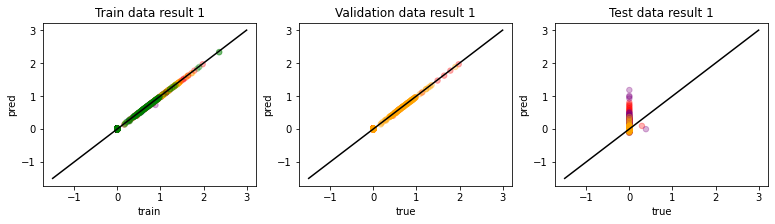

Epoch  33100 Train_loss:  0.0033377486  Validation_loss:  0.0034456467  Test_loss:  0.12847553
Epoch  33200 Train_loss:  0.003338895  Validation_loss:  0.0034432036  Test_loss:  0.1287152
Epoch  33300 Train_loss:  0.003326057  Validation_loss:  0.0034302922  Test_loss:  0.12868907
Epoch  33400 Train_loss:  0.0033027371  Validation_loss:  0.0034092513  Test_loss:  0.12873618
Epoch  33500 Train_loss:  0.0032851712  Validation_loss:  0.003384799  Test_loss:  0.12868923
Epoch  33600 Train_loss:  0.00329449  Validation_loss:  0.0034049395  Test_loss:  0.12854606
Epoch  33700 Train_loss:  0.0032773241  Validation_loss:  0.0033866179  Test_loss:  0.12857477
Epoch  33800 Train_loss:  0.0032868148  Validation_loss:  0.0033936172  Test_loss:  0.12858954
Epoch  33900 Train_loss:  0.0032669443  Validation_loss:  0.00337828  Test_loss:  0.12855728
Epoch  34000 Train_loss:  0.003277865  Validation_loss:  0.0033828693  Test_loss:  0.12845086


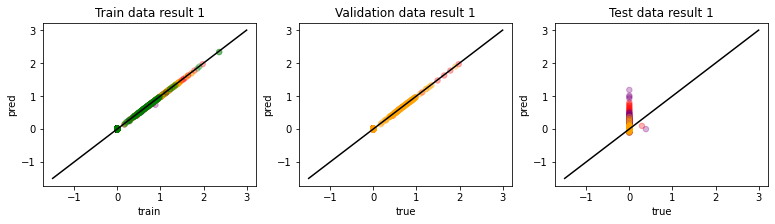

Epoch  34100 Train_loss:  0.003290891  Validation_loss:  0.0034017235  Test_loss:  0.12821907
Epoch  34200 Train_loss:  0.0032536034  Validation_loss:  0.0033516367  Test_loss:  0.12877353
Epoch  34300 Train_loss:  0.0032458424  Validation_loss:  0.0033518472  Test_loss:  0.12866215
Epoch  34400 Train_loss:  0.0032274958  Validation_loss:  0.0033268083  Test_loss:  0.12881964
Epoch  34500 Train_loss:  0.0032365555  Validation_loss:  0.0033426394  Test_loss:  0.12856409
Epoch  34600 Train_loss:  0.0032158403  Validation_loss:  0.003319672  Test_loss:  0.12850195
Epoch  34700 Train_loss:  0.0032166343  Validation_loss:  0.0033320617  Test_loss:  0.12839212
Epoch  34800 Train_loss:  0.003195449  Validation_loss:  0.00330254  Test_loss:  0.12866458
Epoch  34900 Train_loss:  0.0032189947  Validation_loss:  0.0033300659  Test_loss:  0.1281408
Epoch  35000 Train_loss:  0.003202416  Validation_loss:  0.0033163724  Test_loss:  0.12823021


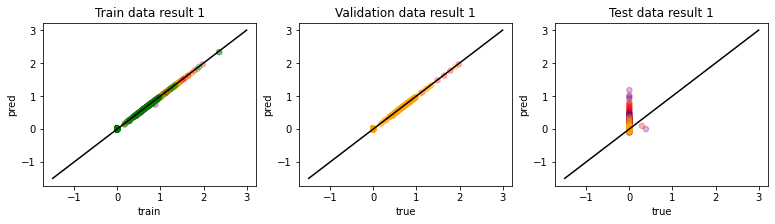

Epoch  35100 Train_loss:  0.0031914883  Validation_loss:  0.0033026093  Test_loss:  0.1284505
Epoch  35200 Train_loss:  0.0031960097  Validation_loss:  0.0033072296  Test_loss:  0.1284306
Epoch  35300 Train_loss:  0.0031636995  Validation_loss:  0.003268388  Test_loss:  0.12851983
Epoch  35400 Train_loss:  0.0031638476  Validation_loss:  0.0032677385  Test_loss:  0.12847406
Epoch  35500 Train_loss:  0.0031555938  Validation_loss:  0.0032509437  Test_loss:  0.12828591
Epoch  35600 Train_loss:  0.0031502224  Validation_loss:  0.0032451309  Test_loss:  0.12849353
Epoch  35700 Train_loss:  0.0031617787  Validation_loss:  0.0032624118  Test_loss:  0.12827727
Epoch  35800 Train_loss:  0.003132001  Validation_loss:  0.003225257  Test_loss:  0.12838235
Epoch  35900 Train_loss:  0.0031182244  Validation_loss:  0.003213638  Test_loss:  0.12841935
Epoch  36000 Train_loss:  0.0031291528  Validation_loss:  0.0032273345  Test_loss:  0.12850729


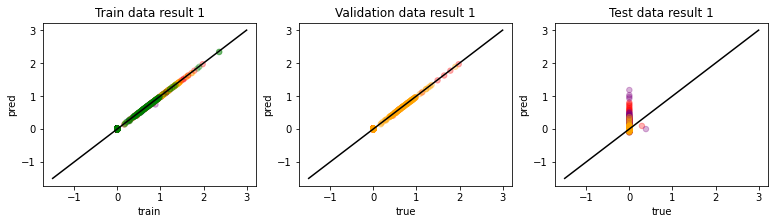

Epoch  36100 Train_loss:  0.0030903579  Validation_loss:  0.0031755392  Test_loss:  0.12899455
Epoch  36200 Train_loss:  0.0031032301  Validation_loss:  0.0031950504  Test_loss:  0.12845893
Epoch  36300 Train_loss:  0.0031038516  Validation_loss:  0.0031962092  Test_loss:  0.12862495
Epoch  36400 Train_loss:  0.0030861336  Validation_loss:  0.0031727068  Test_loss:  0.1285138
Epoch  36500 Train_loss:  0.0030979528  Validation_loss:  0.0031884774  Test_loss:  0.12854506
Epoch  36600 Train_loss:  0.0030899097  Validation_loss:  0.0031770172  Test_loss:  0.12825662
Epoch  36700 Train_loss:  0.0030896296  Validation_loss:  0.003177558  Test_loss:  0.1279803
Epoch  36800 Train_loss:  0.0030792546  Validation_loss:  0.0031639254  Test_loss:  0.12807137
Epoch  36900 Train_loss:  0.003078723  Validation_loss:  0.0031651398  Test_loss:  0.12831078
Epoch  37000 Train_loss:  0.0030539173  Validation_loss:  0.003133461  Test_loss:  0.12847002


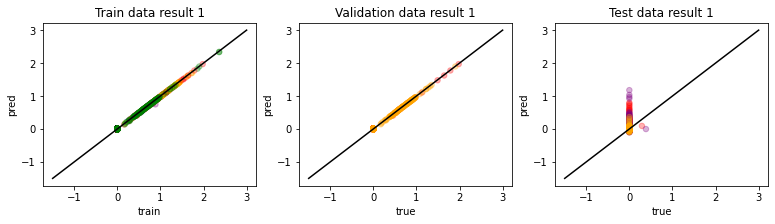

Epoch  37100 Train_loss:  0.003039341  Validation_loss:  0.003127649  Test_loss:  0.12867443
Epoch  37200 Train_loss:  0.0030283933  Validation_loss:  0.003115671  Test_loss:  0.12889934
Epoch  37300 Train_loss:  0.0030319735  Validation_loss:  0.0031164163  Test_loss:  0.1286164
Epoch  37400 Train_loss:  0.0030316168  Validation_loss:  0.0031190405  Test_loss:  0.12875691
Epoch  37500 Train_loss:  0.0030357544  Validation_loss:  0.0031310273  Test_loss:  0.12835467
Epoch  37600 Train_loss:  0.0030081824  Validation_loss:  0.0031009838  Test_loss:  0.12860824
Epoch  37700 Train_loss:  0.0029950887  Validation_loss:  0.0030883313  Test_loss:  0.12881215
Epoch  37800 Train_loss:  0.0030191906  Validation_loss:  0.0031238515  Test_loss:  0.1282973
Epoch  37900 Train_loss:  0.0030066925  Validation_loss:  0.0031014758  Test_loss:  0.12862666
Epoch  38000 Train_loss:  0.0030092364  Validation_loss:  0.0031072241  Test_loss:  0.12846074


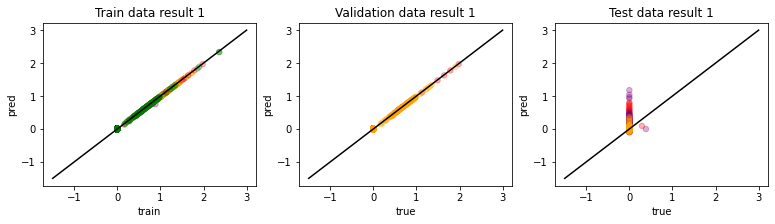

Epoch  38100 Train_loss:  0.0029847063  Validation_loss:  0.0030660979  Test_loss:  0.12850037
Epoch  38200 Train_loss:  0.0029800509  Validation_loss:  0.003062138  Test_loss:  0.12871705
Epoch  38300 Train_loss:  0.0029788807  Validation_loss:  0.0030708355  Test_loss:  0.12846228
Epoch  38400 Train_loss:  0.0029548102  Validation_loss:  0.003042673  Test_loss:  0.12875895
Epoch  38500 Train_loss:  0.002968312  Validation_loss:  0.0030699365  Test_loss:  0.12840258
Epoch  38600 Train_loss:  0.0029642498  Validation_loss:  0.0030668718  Test_loss:  0.12831312
Epoch  38700 Train_loss:  0.002949994  Validation_loss:  0.0030404837  Test_loss:  0.1286238
Epoch  38800 Train_loss:  0.0029474685  Validation_loss:  0.0030411782  Test_loss:  0.12834683
Epoch  38900 Train_loss:  0.0029369101  Validation_loss:  0.003026598  Test_loss:  0.12854265
Epoch  39000 Train_loss:  0.0029451088  Validation_loss:  0.0030372955  Test_loss:  0.12824151


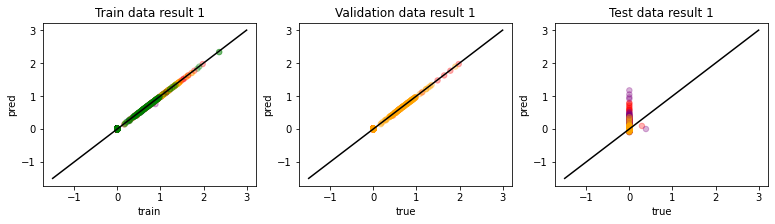

Epoch  39100 Train_loss:  0.0029118857  Validation_loss:  0.0029943557  Test_loss:  0.12867397
Epoch  39200 Train_loss:  0.0029213761  Validation_loss:  0.0030132271  Test_loss:  0.12858795
Epoch  39300 Train_loss:  0.0029090606  Validation_loss:  0.0030003109  Test_loss:  0.12867683
Epoch  39400 Train_loss:  0.0029178972  Validation_loss:  0.0030114467  Test_loss:  0.12863535
Epoch  39500 Train_loss:  0.002916971  Validation_loss:  0.003016771  Test_loss:  0.12851787
Epoch  39600 Train_loss:  0.0029107397  Validation_loss:  0.0030108497  Test_loss:  0.12863386
Epoch  39700 Train_loss:  0.002908349  Validation_loss:  0.0030061062  Test_loss:  0.12834434
Epoch  39800 Train_loss:  0.0029020594  Validation_loss:  0.0030005502  Test_loss:  0.12860854
Epoch  39900 Train_loss:  0.0028675036  Validation_loss:  0.002962814  Test_loss:  0.12895112
Epoch  40000 Train_loss:  0.0028791286  Validation_loss:  0.0029770993  Test_loss:  0.12838234


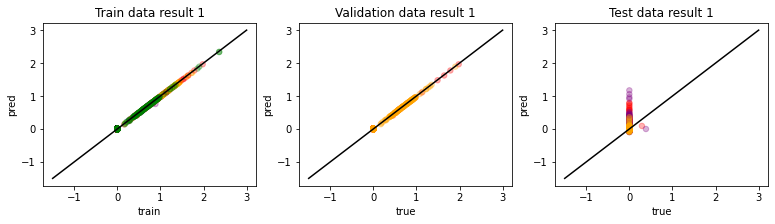

Epoch  40100 Train_loss:  0.0028623154  Validation_loss:  0.0029608696  Test_loss:  0.12828591
Epoch  40200 Train_loss:  0.002864328  Validation_loss:  0.002965124  Test_loss:  0.12841763
Epoch  40300 Train_loss:  0.0028449371  Validation_loss:  0.0029316088  Test_loss:  0.12840825
Epoch  40400 Train_loss:  0.0028614167  Validation_loss:  0.002961866  Test_loss:  0.12856235
Epoch  40500 Train_loss:  0.00284772  Validation_loss:  0.002948265  Test_loss:  0.12856528
Epoch  40600 Train_loss:  0.002822306  Validation_loss:  0.0029122415  Test_loss:  0.12891929
Epoch  40700 Train_loss:  0.0028175525  Validation_loss:  0.0029032815  Test_loss:  0.12861364
Epoch  40800 Train_loss:  0.0028156515  Validation_loss:  0.00290481  Test_loss:  0.1285289
Epoch  40900 Train_loss:  0.002822452  Validation_loss:  0.0029123672  Test_loss:  0.12842919
Epoch  41000 Train_loss:  0.0028190159  Validation_loss:  0.0029099733  Test_loss:  0.12851502


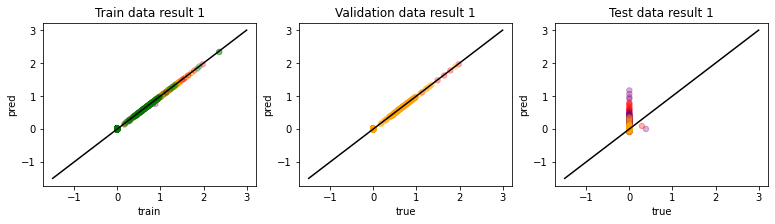

Epoch  41100 Train_loss:  0.0028034677  Validation_loss:  0.0028886234  Test_loss:  0.12836698
Epoch  41200 Train_loss:  0.002787982  Validation_loss:  0.0028715602  Test_loss:  0.12856512
Epoch  41300 Train_loss:  0.002823536  Validation_loss:  0.0029201028  Test_loss:  0.12817413
Epoch  41400 Train_loss:  0.0027800947  Validation_loss:  0.002866959  Test_loss:  0.12864451
Epoch  41500 Train_loss:  0.0027987696  Validation_loss:  0.002892527  Test_loss:  0.12808047
Epoch  41600 Train_loss:  0.002805419  Validation_loss:  0.0029029641  Test_loss:  0.12795681
Epoch  41700 Train_loss:  0.0027651342  Validation_loss:  0.0028558932  Test_loss:  0.12856841
Epoch  41800 Train_loss:  0.0027753685  Validation_loss:  0.002875891  Test_loss:  0.12835318
Epoch  41900 Train_loss:  0.002758336  Validation_loss:  0.0028450312  Test_loss:  0.12842478
Epoch  42000 Train_loss:  0.0027571844  Validation_loss:  0.002843093  Test_loss:  0.12838043


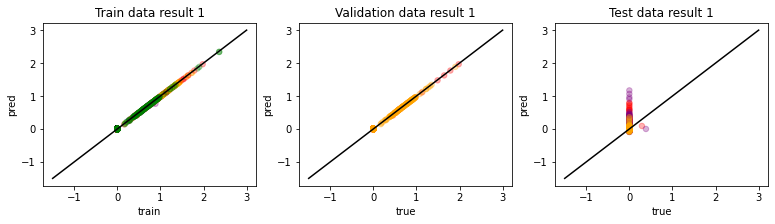

Epoch  42100 Train_loss:  0.0027768435  Validation_loss:  0.0028657122  Test_loss:  0.12857807
Epoch  42200 Train_loss:  0.0027669023  Validation_loss:  0.002853081  Test_loss:  0.12827434
Epoch  42300 Train_loss:  0.002757212  Validation_loss:  0.0028460165  Test_loss:  0.12831552
Epoch  42400 Train_loss:  0.0027416504  Validation_loss:  0.0028124268  Test_loss:  0.12856075
Epoch  42500 Train_loss:  0.00274769  Validation_loss:  0.0028323745  Test_loss:  0.12832856
Epoch  42600 Train_loss:  0.0027562175  Validation_loss:  0.0028524806  Test_loss:  0.1281683
Epoch  42700 Train_loss:  0.0027468593  Validation_loss:  0.0028377357  Test_loss:  0.12823416
Epoch  42800 Train_loss:  0.0027216016  Validation_loss:  0.002806619  Test_loss:  0.12875323
Epoch  42900 Train_loss:  0.002716239  Validation_loss:  0.002801489  Test_loss:  0.12853484
Epoch  43000 Train_loss:  0.0027210747  Validation_loss:  0.0028076428  Test_loss:  0.12837102


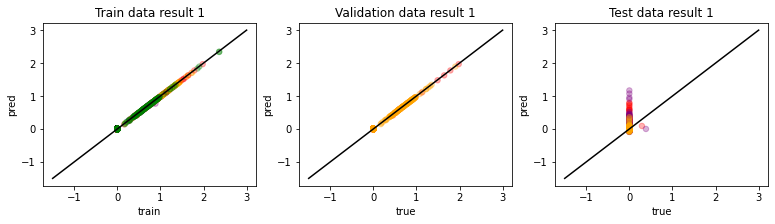

Epoch  43100 Train_loss:  0.0026842426  Validation_loss:  0.0027621442  Test_loss:  0.12864733
Epoch  43200 Train_loss:  0.0026956408  Validation_loss:  0.0027822868  Test_loss:  0.12818925
Epoch  43300 Train_loss:  0.0027056357  Validation_loss:  0.0027938199  Test_loss:  0.12819865
Epoch  43400 Train_loss:  0.0027019337  Validation_loss:  0.0027856736  Test_loss:  0.12831323
Epoch  43500 Train_loss:  0.0027091869  Validation_loss:  0.0027917656  Test_loss:  0.12813284
Epoch  43600 Train_loss:  0.0026941085  Validation_loss:  0.0027785532  Test_loss:  0.12814018
Epoch  43700 Train_loss:  0.0027023186  Validation_loss:  0.0027968923  Test_loss:  0.12807691
Epoch  43800 Train_loss:  0.0026769286  Validation_loss:  0.0027601721  Test_loss:  0.12826675
Epoch  43900 Train_loss:  0.002664692  Validation_loss:  0.002744509  Test_loss:  0.12830555
Epoch  44000 Train_loss:  0.0026829639  Validation_loss:  0.0027710677  Test_loss:  0.1281531


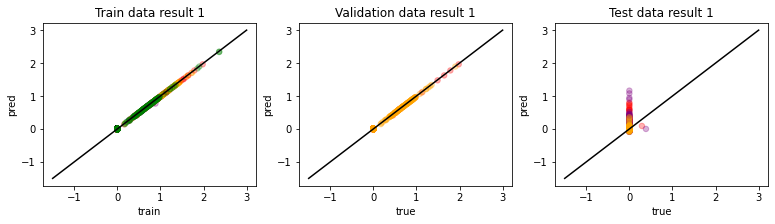

Epoch  44100 Train_loss:  0.0026669842  Validation_loss:  0.0027476372  Test_loss:  0.12820782
Epoch  44200 Train_loss:  0.002668572  Validation_loss:  0.002750275  Test_loss:  0.12793364
Epoch  44300 Train_loss:  0.002647585  Validation_loss:  0.0027268662  Test_loss:  0.12810515
Epoch  44400 Train_loss:  0.0026465834  Validation_loss:  0.0027254096  Test_loss:  0.12807147
Epoch  44500 Train_loss:  0.0026490889  Validation_loss:  0.0027246673  Test_loss:  0.1283426
Epoch  44600 Train_loss:  0.0026288927  Validation_loss:  0.00270775  Test_loss:  0.12846582
Epoch  44700 Train_loss:  0.0026499154  Validation_loss:  0.002734223  Test_loss:  0.12814586
Epoch  44800 Train_loss:  0.0026346259  Validation_loss:  0.0027211145  Test_loss:  0.12848349
Epoch  44900 Train_loss:  0.0026418706  Validation_loss:  0.0027352462  Test_loss:  0.12820807
Epoch  45000 Train_loss:  0.002617032  Validation_loss:  0.0027069128  Test_loss:  0.12836063


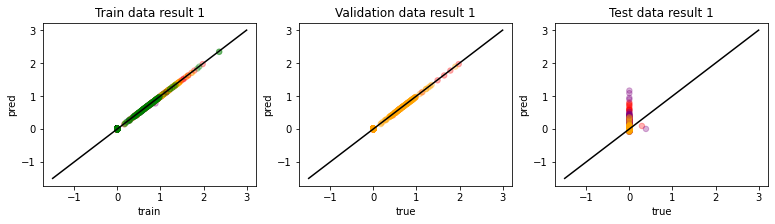

Epoch  45100 Train_loss:  0.0026186144  Validation_loss:  0.002706233  Test_loss:  0.1282376
Epoch  45200 Train_loss:  0.002626237  Validation_loss:  0.0027184475  Test_loss:  0.12820089
Epoch  45300 Train_loss:  0.0026043318  Validation_loss:  0.0026974701  Test_loss:  0.12842225
Epoch  45400 Train_loss:  0.0026170665  Validation_loss:  0.0027210834  Test_loss:  0.12829979
Epoch  45500 Train_loss:  0.0026073216  Validation_loss:  0.0027106327  Test_loss:  0.12838648
Epoch  45600 Train_loss:  0.0026197634  Validation_loss:  0.0027190892  Test_loss:  0.12802085
Epoch  45700 Train_loss:  0.0025980442  Validation_loss:  0.0026941982  Test_loss:  0.12858972
Epoch  45800 Train_loss:  0.0026231816  Validation_loss:  0.00272337  Test_loss:  0.12802197
Epoch  45900 Train_loss:  0.0026136525  Validation_loss:  0.0027109133  Test_loss:  0.12792198
Epoch  46000 Train_loss:  0.0025836567  Validation_loss:  0.0026768344  Test_loss:  0.12820128


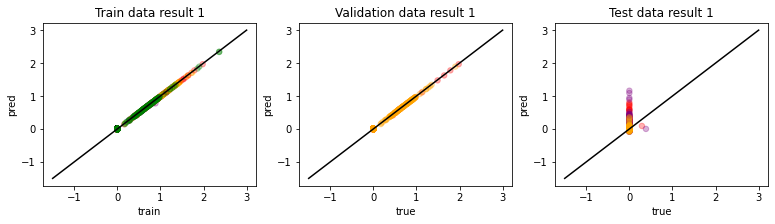

Epoch  46100 Train_loss:  0.0025703674  Validation_loss:  0.0026540456  Test_loss:  0.12795539
Epoch  46200 Train_loss:  0.002602859  Validation_loss:  0.0026967095  Test_loss:  0.12783977
Epoch  46300 Train_loss:  0.0025533321  Validation_loss:  0.0026309956  Test_loss:  0.12841061
Epoch  46400 Train_loss:  0.002586524  Validation_loss:  0.0026749943  Test_loss:  0.127851
Epoch  46500 Train_loss:  0.0025683986  Validation_loss:  0.0026526926  Test_loss:  0.1278126
Epoch  46600 Train_loss:  0.0025726997  Validation_loss:  0.0026575031  Test_loss:  0.1278503
Epoch  46700 Train_loss:  0.002557122  Validation_loss:  0.0026371176  Test_loss:  0.12808861
Epoch  46800 Train_loss:  0.0025471805  Validation_loss:  0.0026271038  Test_loss:  0.12825139
Epoch  46900 Train_loss:  0.0025301003  Validation_loss:  0.0026073004  Test_loss:  0.12852979
Epoch  47000 Train_loss:  0.0025619736  Validation_loss:  0.0026541885  Test_loss:  0.12792636


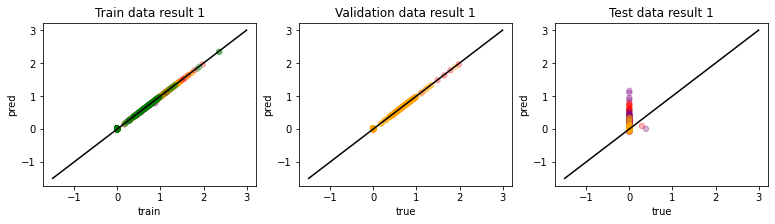

Epoch  47100 Train_loss:  0.0025694454  Validation_loss:  0.0026575164  Test_loss:  0.12804689
Epoch  47200 Train_loss:  0.0025725188  Validation_loss:  0.002661994  Test_loss:  0.12793389
Epoch  47300 Train_loss:  0.0025504015  Validation_loss:  0.0026291416  Test_loss:  0.12802073
Epoch  47400 Train_loss:  0.0025556604  Validation_loss:  0.0026403067  Test_loss:  0.12809056
Epoch  47500 Train_loss:  0.0025364037  Validation_loss:  0.0026216493  Test_loss:  0.12811838
Epoch  47600 Train_loss:  0.0025288623  Validation_loss:  0.002611007  Test_loss:  0.12828246
Epoch  47700 Train_loss:  0.0025541063  Validation_loss:  0.0026454814  Test_loss:  0.12797062
Epoch  47800 Train_loss:  0.0025378144  Validation_loss:  0.0026274633  Test_loss:  0.12800291
Epoch  47900 Train_loss:  0.0025397115  Validation_loss:  0.0026362475  Test_loss:  0.12772027
Epoch  48000 Train_loss:  0.0025097043  Validation_loss:  0.0025996289  Test_loss:  0.1280183


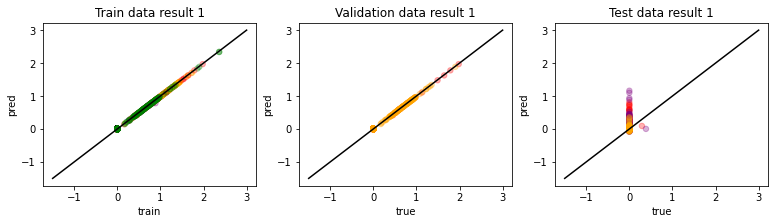

Epoch  48100 Train_loss:  0.002509223  Validation_loss:  0.0025880586  Test_loss:  0.12788518
Epoch  48200 Train_loss:  0.00247133  Validation_loss:  0.0025434964  Test_loss:  0.12834378
Epoch  48300 Train_loss:  0.002502482  Validation_loss:  0.002592584  Test_loss:  0.12792705
Epoch  48400 Train_loss:  0.0025087034  Validation_loss:  0.002593362  Test_loss:  0.12793414
Epoch  48500 Train_loss:  0.0024987417  Validation_loss:  0.0025798792  Test_loss:  0.12797384
Epoch  48600 Train_loss:  0.002470394  Validation_loss:  0.0025417597  Test_loss:  0.12831815
Epoch  48700 Train_loss:  0.0024704442  Validation_loss:  0.0025466834  Test_loss:  0.12813874
Epoch  48800 Train_loss:  0.002473251  Validation_loss:  0.0025474413  Test_loss:  0.12812094
Epoch  48900 Train_loss:  0.0024679683  Validation_loss:  0.0025405688  Test_loss:  0.12812318
Epoch  49000 Train_loss:  0.002470416  Validation_loss:  0.0025435842  Test_loss:  0.12810056


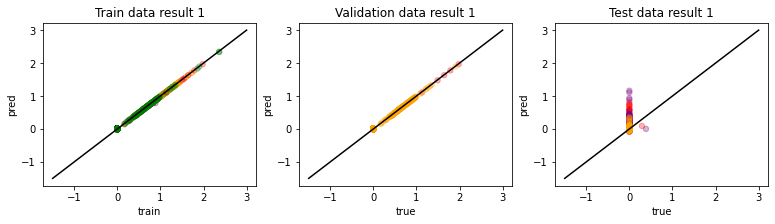

Epoch  49100 Train_loss:  0.0024957454  Validation_loss:  0.0025723907  Test_loss:  0.12780333
Epoch  49200 Train_loss:  0.0024685673  Validation_loss:  0.0025371402  Test_loss:  0.12801889
Epoch  49300 Train_loss:  0.0024504655  Validation_loss:  0.002526093  Test_loss:  0.12825102
Epoch  49400 Train_loss:  0.002433329  Validation_loss:  0.0025019627  Test_loss:  0.12829936
Epoch  49500 Train_loss:  0.002436806  Validation_loss:  0.0025211803  Test_loss:  0.12825206
Epoch  49600 Train_loss:  0.002432377  Validation_loss:  0.0025203393  Test_loss:  0.12819901
Epoch  49700 Train_loss:  0.0024228732  Validation_loss:  0.0025179198  Test_loss:  0.12815486
Epoch  49800 Train_loss:  0.002455827  Validation_loss:  0.0025522332  Test_loss:  0.12802829
Epoch  49900 Train_loss:  0.002444399  Validation_loss:  0.002534836  Test_loss:  0.12794156
Epoch  50000 Train_loss:  0.0024338323  Validation_loss:  0.0025268435  Test_loss:  0.12805013


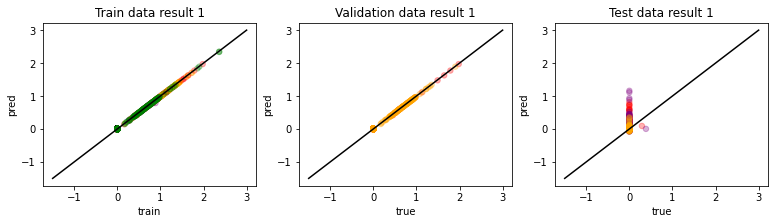

In [43]:
num_epochs = 50001
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
model.load_state_dict(torch.load(PATH))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)